In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import json
from collections import Counter
import numpy as np
import os
import shutil
import json
import random
from collections import defaultdict
import random

## Utils functions

In [2]:
def check_img_annot(path_img, path_txt):
    frame = cv2.imread(path_img).copy()
    box = []
    with open(path_txt, "r") as f:
        for i in f:
            box.append(i.split())
    #print("box : class, x, y, w, h \n", box)
    f.close()

    for boxx in box:
        
        cl,x,y,w,h = [eval(i) for i in boxx]

        h_frame,w_frame,channel = frame.shape

        # top left
        xtl = int(x*w_frame-w*w_frame/2)
        ytl = int(y*h_frame+h*h_frame/2)

        # bottom right
        xbr = int(x*w_frame+w*w_frame/2)
        ybr = int(y*h_frame-h*h_frame/2)

        frame = cv2.rectangle(frame, (xtl,ytl),(xbr,ybr),(0,255,0),2 )

    plt.imshow(frame)
    plt.show()

In [3]:
def coco_to_yolo(coco_bbox, image_width, image_height):
    x_min, y_min, width, height = coco_bbox
    
    # COCO format to YOLO format
    center_x = (x_min + width / 2) / image_width
    center_y = (y_min + height / 2) / image_height
    yolo_width = width / image_width
    yolo_height = height / image_height
    
    return [center_x, center_y, yolo_width, yolo_height]

def yolo_to_coco(yolo_bbox, image_width, image_height):
    center_x, center_y, yolo_width, yolo_height = yolo_bbox
    
    # YOLO format to COCO format
    x_min = int((center_x - yolo_width / 2) * image_width)
    y_min = int((center_y - yolo_height / 2) * image_height)
    width = int(yolo_width * image_width)
    height = int(yolo_height * image_height)
    
    return [x_min, y_min, width, height]

In [4]:
def get_data(video_path, annotation_path, data_save_path, per=1, 
             per_train=80, per_val=10):
    info = {}

    # IMAGES WITH ANNOTATION
    data = json.load(open(annotation_path))
    set_img = {i["image_id"] for i in data["annotations"]}

    # REDIMENTION OF IMG
    cap = cv2.VideoCapture(video_path)
    _,frame = cap.read()
    Ho,Wo,_=frame.shape
    r = frame.shape[0]/frame.shape[1] # H/W
    new_W = frame.shape[1]/per
    new_H = r*new_W
    dim = (int(new_W), int(new_H))
    
    
    try:
        os.mkdir(os.path.join(data_save_path,"images"))
    except:
        print("directory 'images' was created")
        print("all new file will be add")
        print()
    
    # SAVE IMAGES WITH ANNOTATIONS IN "images"
    count = 1
    cap = cv2.VideoCapture(video_path)
    success, frame = cap.read()
    name_video = video_path.split("/")[-1].split(".")[0]
    
    while success:
        name = os.path.join(data_save_path,"images",
                            name_video+"_frame_"+str(count)+".png")
        if count in set_img:
            resized = cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)
            cv2.imwrite(name,resized)  # SAVE IMG
        success, frame = cap.read()
        count = count + 1
    cap.release()
    
    # SAVE ANNOTATION .TXT IN "labels"
    try:
        os.mkdir(os.path.join(data_save_path, "labels"))
    except:
        print("directory 'labels' was created")
        print("all news files will be add")
            
    for i in data["annotations"]:
        f = open(os.path.join(data_save_path,"labels",
                              name_video+"_frame_"+str(i["image_id"])+".txt"),"a")
        f.write(str(int(i["category_id"]-1))+ " ")
    
        # cl,x,y,w,h = [eval(i) for i in boxx] YOLO
        # # Bboxes are in [top-left-x, top-left-y, width, height]  COCO
        box = coco_to_yolo(i["bbox"], new_W, new_H)

        # due of resized
        box[0] = box[0]*new_W/Wo
        box[1] = box[1]*new_H/Ho
        box[2] = box[2]*new_W/Wo
        box[3] = box[3]*new_H/Ho
        
        for b in box:
            f.write( f"{b:.5f}" + " ")
        f.write("\n")
        f.close()
    
    # CREATE VAL, TEST, TRAIN
    '''
    labels = os.listdir(os.path.join(data_save_path,"labels"))
    train_labels = labels[0:int((len(labels) * per_train)/100)]
    val_labels = labels[int((len(labels) * per_train)/100):int((len(labels) * (per_train+per_val))/100)]
    test_labels = labels[int(len(labels) * (per_val+per_train)/100):]
    
    print("Directories to train")
    print("total : ", len(labels))
    print("train : ", len(train_labels))
    print("test  : ", len(test_labels))
    print("val   : ", len(val_labels))

    # copy images to train, val and test folders
    try:
        os.mkdir(os.path.join(data_save_path,"Train"))
    except:
        print("directory 'Train' was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Train","images"))
    except:
        print("directory 'Train/images' was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Train","labels"))
    except:
        print("directory was created")
        print("all new file will be add")

    for label in train_labels:
        filename = label.split(".")[0]
        #path = os.getcwd()
        # images source and destination path
        img_src = data_save_path+"/images/"+filename+'.png'
        img_dst = data_save_path+'/Train/images/'+filename+'.png'
        # labels source and destination path
        label_src = data_save_path+'/labels/'+filename+'.txt'
        label_dst = data_save_path+'/Train/labels/'+filename+'.txt'
        
        shutil.copy(img_src, img_dst)
        shutil.copy(label_src, label_dst)

    try:
        os.mkdir(os.path.join(data_save_path,"Val"))
    except:
        print("directory 'Val' was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Val","images"))
    except:
        print("directory 'Val/images' created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Val","labels"))
    except:
        print("directory was created")
        print("all new file will be add")


    for label in val_labels:
        filename = label.split(".")[0]
        #path = os.getcwd()
        # images source and destination path
        img_src = data_save_path+'/images/'+filename+'.png'
        img_dst = data_save_path+'/Val/images/'+filename+'.png'
        # labels source and destination path
        label_src = data_save_path+'/labels/'+filename+'.txt'
        label_dst = data_save_path+'/Val/labels/'+filename+'.txt'
        
        shutil.copy(img_src, img_dst)
        shutil.copy(label_src, label_dst)

    try:
        os.mkdir(os.path.join(data_save_path,"Test"))
    except:
        print("directory was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Test","images"))
    except:
        print("directory was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Test","labels"))
    except:
        print("directory was created")
        print("all new file will be add")


    for label in test_labels:
        filename = label.split(".")[0]
        #path = os.getcwd()
        # images source and destination path
        img_src = data_save_path+'/images/'+filename+'.png'
        img_dst = data_save_path+'/Test/images/'+filename+'.png'
        # labels source and destination path
        label_src = data_save_path+'/labels/'+filename+'.txt'
        label_dst = data_save_path+'/Test/labels/'+filename+'.txt'
        
        shutil.copy(img_src, img_dst)
        shutil.copy(label_src, label_dst)
'''

    info["categories"] = data["categories"]
    return info


# Get Raster Data

In [8]:
data = json.load(open('../data/video1.json'))

In [26]:
info = get_data(video_path="../data/video1.mp4", 
         annotation_path="../data/video1.json",
         data_save_path="../data/dataset", per=1)

In [27]:
info = get_data(video_path="../data/video2.mp4", 
         annotation_path="../data/video2.json",
         data_save_path="../data/dataset", per=1)

directory 'images' was created
all new file will be add

directory 'labels' was created
all news files will be add


In [28]:
info = get_data(video_path="../data/video3.mp4", 
         annotation_path="../data/video3.json",
         data_save_path="../data/dataset", per=1)

directory 'images' was created
all new file will be add

directory 'labels' was created
all news files will be add


In [29]:
info = get_data(video_path="../data/video4.mp4", 
         annotation_path="../data/video4.json",
         data_save_path="../data/dataset", per=1)

directory 'images' was created
all new file will be add

directory 'labels' was created
all news files will be add


In [30]:
info = get_data(video_path="../data/video5.mp4", 
         annotation_path="../data/video5.json",
         data_save_path="../data/dataset", per=1)

directory 'images' was created
all new file will be add

directory 'labels' was created
all news files will be add


# Train-Test dataset

In [10]:
len(set(os.listdir('../data/dataset/images')))

4862

In [28]:
val_percent = 0.2
test_size = 0.2

In [29]:
categories = [{'id': 1, 'name': '1_Auto Privado', 'supercategory': ''},
              {'id': 2, 'name': '13_Bus', 'supercategory': ''},
              {'id': 3, 'name': '11_Camioneta rural', 'supercategory': ''},
              {'id': 4, 'name': '12_Microbus', 'supercategory': ''},
              {'id': 5, 'name': '4_Mototaxi', 'supercategory': ''},
              {'id': 6, 'name': '5_Moto lineal', 'supercategory': ''},
              {'id': 7, 'name': '9_Omnibus Interprovincial', 'supercategory': ''},
              {'id': 8, 'name': '10_Auto colectivo', 'supercategory': ''},
              {'id': 9, 'name': '14_Articulado', 'supercategory': ''},
              {'id': 10, 'name': '2_Cam. PickUp', 'supercategory': ''},
              {'id': 11, 'name': '3_Taxi', 'supercategory': ''},
              {'id': 12, 'name': '6_Bicicletas', 'supercategory': ''},
              {'id': 13, 'name': '7_Scooter', 'supercategory': ''},
              {'id': 14, 'name': '8_TransportenEscolar Personal', 'supercategory': ''},
              {'id': 15, 'name': '15_TC_Ligeros', 'supercategory': ''},
              {'id': 16, 'name': '16_TC Pesados', 'supercategory': ''},
              {'id': 17, 'name': '17_TC SemiTrailler Trailer', 'supercategory': ''},
              {'id': 18, 'name': '18_Triciclo', 'supercategory': ''},
              {'id': 19, 'name': '19_Ambulancia', 'supercategory': ''}]

### Split stratiefd

In [ ]:


txt_dir = '../data/dataset/labels'

#image_to_classes
class_to_images = defaultdict(list)
image_to_classes = {}
for txt_file in os.listdir(txt_dir):
        if txt_file.endswith('.txt'):
            image_name = txt_file.replace('.txt', '.png')  # Assuming images are in .jpg format
            with open(os.path.join(txt_dir, txt_file), 'r') as file:
                classes_in_image = set()
                for line in file:
                    class_label = line.split()[0]  # Assuming class label is the first entry in each row
                    class_to_images[class_label].append(image_name)
                    classes_in_image.add(class_label)
                image_to_classes[image_name] = list(classes_in_image)

# Step 1: Count the occurrences of each class across all images
class_counts = Counter()
for classes in image_to_classes.values():
    class_counts.update(classes)
# Step 2: Define a proportional split (e.g., 80% train, 20% test)
train_set = {}
test_set = {}
current_test_counts = Counter()
# Step 3: Split the data while maintaining proportionality
for image, classes in image_to_classes.items():
    if all(current_test_counts[cls] / class_counts[cls] <= test_size for cls in classes):
        test_set[image] = classes
        current_test_counts.update(classes)
    else:
        train_set[image] = classes


# Print the result
print(f"Train set: {len(train_set)} images")
print(f"Test set: {len(test_set)} images")

Train set: 3965 images
Test set: 897 images


In [111]:
import os
from collections import defaultdict, Counter

# Set directory path
txt_dir = '../data/dataset/labels'

# image_to_classes: Mapping from image file to list of class labels
class_to_images = defaultdict(list)
image_to_classes = {}

# Load all the text files and associate each image with its classes
for txt_file in os.listdir(txt_dir):
    if txt_file.endswith('.txt'):
        image_name = txt_file.replace('.txt', '.png')  # Assuming images are in .png format
        with open(os.path.join(txt_dir, txt_file), 'r') as file:
            classes_in_image = set()  # Set to store unique class labels for each image
            for line in file:
                class_label = line.split()[0]  # Assuming class label is the first entry in each row
                class_to_images[class_label].append(image_name)
                classes_in_image.add(class_label)  # Add the class to the set
            image_to_classes[image_name] = list(classes_in_image)

# Step 1: Count the occurrences of each class across all images
class_counts = Counter()
for classes in image_to_classes.values():
    class_counts.update(classes)

# Step 2: Define a proportional split (e.g., 80% train, 20% test)
train_set = {}
test_set = {}
current_test_counts = Counter()

# Test size threshold (20% split for test set)
test_size = 0.2

# Step 3: Split the data while maintaining proportionality
for image, classes in image_to_classes.items():
    # Calculate the current proportions of classes in the test set
    if all(current_test_counts[cls] / class_counts[cls] <= test_size for cls in classes):
        test_set[image] = classes
        current_test_counts.update(classes)  # Update test set counts for each class
    else:
        train_set[image] = classes  # Add to training set if proportions are satisfied

# Print the result
print(f"Train set: {len(train_set)} images")
print(f"Test set: {len(test_set)} images")

# Optionally, you can also check the class distribution in train and test sets
train_class_counts = Counter([cls for classes in train_set.values() for cls in classes])
test_class_counts = Counter([cls for classes in test_set.values() for cls in classes])

print("\nClass distribution in Train set:")
for class_label, count in train_class_counts.items():
    print(f"{class_label}: {count} instances")

print("\nClass distribution in Test set:")
for class_label, count in test_class_counts.items():
    print(f"{class_label}: {count} instances")


Train set: 3965 images
Test set: 897 images

Class distribution in Train set:
6: 42 instances
1: 2897 instances
5: 1702 instances
8: 1778 instances
10: 1673 instances
0: 3221 instances
2: 2635 instances
13: 59 instances
9: 212 instances
7: 535 instances
18: 27 instances
4: 320 instances
11: 584 instances
14: 232 instances
3: 229 instances
15: 110 instances
12: 12 instances
17: 101 instances
16: 30 instances

Class distribution in Test set:
10: 407 instances
5: 426 instances
1: 725 instances
0: 615 instances
7: 135 instances
8: 445 instances
2: 660 instances
6: 11 instances
11: 54 instances
13: 16 instances
4: 29 instances
3: 38 instances
9: 54 instances
18: 7 instances
14: 15 instances
15: 6 instances
12: 3 instances
17: 4 instances


In [109]:
import os
from collections import defaultdict, Counter

# Set directory path
txt_dir = '../data/dataset/labels'

# image_to_classes: Mapping from image file to list of class labels
class_to_images = defaultdict(list)
image_to_classes = {}

# Load all the text files and associate each image with its classes
for txt_file in os.listdir(txt_dir):
    if txt_file.endswith('.txt'):
        image_name = txt_file.replace('.txt', '.png')  # Assuming images are in .png format
        with open(os.path.join(txt_dir, txt_file), 'r') as file:
            classes_in_image = set()  # Set to store unique class labels for each image
            for line in file:
                class_label = line.split()[0]  # Assuming class label is the first entry in each row
                class_to_images[class_label].append(image_name)
                classes_in_image.add(class_label)  # Add the class to the set
            image_to_classes[image_name] = list(classes_in_image)

# Step 1: Count the occurrences of each class across all images
class_counts = Counter()
for classes in image_to_classes.values():
    class_counts.update(classes)

# Step 2: Define proportional splits for train, test, and validation sets
train_set = {}
test_set = {}
val_set = {}

# Thresholds for splitting
test_size = 0.2  # 20% for test set
val_size = 0.2  # 20% for validation set
current_test_counts = Counter()
current_val_counts = Counter()

# Step 3: Split the data while maintaining proportionality
for image, classes in image_to_classes.items():
    # Check if we can add to the test set
    if all(current_test_counts[cls] / class_counts[cls] <= test_size for cls in classes):
        test_set[image] = classes
        current_test_counts.update(classes)
    # Check if we can add to the validation set (if it doesn't go over the val_size)
    elif all(current_val_counts[cls] / class_counts[cls] <= val_size for cls in classes):
        val_set[image] = classes
        current_val_counts.update(classes)
    else:
        # Otherwise, add to the train set
        train_set[image] = classes

# Print the result
print(f"Train set: {len(train_set)} images")
print(f"Test set: {len(test_set)} images")
print(f"Validation set: {len(val_set)} images")

# Optionally, you can also check the class distribution in train, test, and validation sets
train_class_counts = Counter([cls for classes in train_set.values() for cls in classes])
test_class_counts = Counter([cls for classes in test_set.values() for cls in classes])
val_class_counts = Counter([cls for classes in val_set.values() for cls in classes])

print("\nClass distribution in Train set:")
for class_label, count in train_class_counts.items():
    print(f"{class_label}: {count} instances")

print("\nClass distribution in Test set:")
for class_label, count in test_class_counts.items():
    print(f"{class_label}: {count} instances")

print("\nClass distribution in Validation set:")
for class_label, count in val_class_counts.items():
    print(f"{class_label}: {count} instances")


Train set: 2975 images
Test set: 897 images
Validation set: 990 images

Class distribution in Train set:
10: 1256 instances
2: 1975 instances
0: 2453 instances
1: 2184 instances
9: 187 instances
7: 400 instances
6: 31 instances
8: 1333 instances
5: 1276 instances
18: 20 instances
14: 200 instances
4: 295 instances
11: 456 instances
15: 106 instances
3: 175 instances
13: 43 instances
12: 8 instances
16: 30 instances
17: 94 instances

Class distribution in Test set:
10: 407 instances
5: 426 instances
1: 725 instances
0: 615 instances
7: 135 instances
8: 445 instances
2: 660 instances
6: 11 instances
11: 54 instances
13: 16 instances
4: 29 instances
3: 38 instances
9: 54 instances
18: 7 instances
14: 15 instances
15: 6 instances
12: 3 instances
17: 4 instances

Class distribution in Validation set:
6: 11 instances
1: 713 instances
5: 426 instances
8: 445 instances
10: 417 instances
0: 768 instances
2: 660 instances
13: 16 instances
9: 25 instances
7: 135 instances
18: 7 instances
4: 25 in

In [118]:
import os
from collections import defaultdict, Counter

# Set directory path
txt_dir = '../data/dataset/labels'

# image_to_classes: Mapping from image file to list of class labels (with possible duplicates)
class_to_images = defaultdict(list)
image_to_classes = {}

# Load all the text files and associate each image with its classes
for txt_file in os.listdir(txt_dir):
    if txt_file.endswith('.txt'):
        image_name = txt_file.replace('.txt', '.png')  # Assuming images are in .png format
        with open(os.path.join(txt_dir, txt_file), 'r') as file:
            classes_in_image = []  # List to store all class labels (including duplicates)
            for line in file:
                class_label = line.split()[0]  # Assuming class label is the first entry in each row
                class_to_images[class_label].append(image_name)
                classes_in_image.append(class_label)  # Add the class to the list (including duplicates)
            image_to_classes[image_name] = classes_in_image  # Store all classes (including duplicates)

# Step 1: Count the occurrences of each class across all images
class_counts = Counter()
for classes in image_to_classes.values():
    class_counts.update(classes)  # Count each class occurrence, including duplicates

# Step 2: Define a proportional split (e.g., 80% train, 20% test)
train_set = {}
test_set = {}
current_test_counts = Counter()

# Test size threshold (20% split for test set)
test_size = 0.2

# Step 3: Split the data while maintaining proportionality
for image, classes in image_to_classes.items():
    # Calculate the current proportions of classes in the test set
    if all(current_test_counts[cls] / class_counts[cls] <= test_size for cls in classes):
        test_set[image] = classes
        current_test_counts.update(classes)  # Update test set counts for each class
    else:
        train_set[image] = classes  # Add to training set if proportions are satisfied

# Print the result
print(f"Train set: {len(train_set)} images")
print(f"Test set: {len(test_set)} images")

# Optionally, you can also check the class distribution in train and test sets
train_class_counts = Counter([cls for classes in train_set.values() for cls in classes])
test_class_counts = Counter([cls for classes in test_set.values() for cls in classes])

print("\nClass distribution in Train set:")
for class_label, count in train_class_counts.items():
    print(f"{class_label}: {count} instances")

print("\nClass distribution in Test set:")
for class_label, count in test_class_counts.items():
    print(f"{class_label}: {count} instances")

# Final overall class counts (including repeated classes)
print("\nOverall class counts (including duplicates):")
for class_label, count in class_counts.items():
    print(f"{class_label}: {count} instances")


Train set: 4002 images
Test set: 860 images

Class distribution in Train set:
1: 4565 instances
8: 1963 instances
6: 42 instances
5: 2120 instances
13: 59 instances
10: 2264 instances
2: 4002 instances
0: 8063 instances
9: 223 instances
7: 562 instances
18: 27 instances
4: 350 instances
14: 238 instances
11: 670 instances
3: 247 instances
15: 137 instances
12: 12 instances
17: 103 instances
16: 30 instances

Class distribution in Test set:
10: 567 instances
1: 1142 instances
5: 531 instances
0: 1267 instances
7: 133 instances
8: 492 instances
2: 1001 instances
6: 11 instances
11: 56 instances
13: 16 instances
4: 28 instances
3: 45 instances
9: 56 instances
18: 7 instances
14: 18 instances
15: 6 instances
12: 3 instances
17: 2 instances

Overall class counts (including duplicates):
10: 2831 instances
1: 5707 instances
5: 2651 instances
0: 9330 instances
7: 695 instances
8: 2455 instances
2: 5003 instances
6: 53 instances
11: 726 instances
13: 75 instances
4: 378 instances
3: 292 instanc

In [120]:
import os
from collections import defaultdict, Counter

# Set directory path
txt_dir = '../data/dataset/labels'

# image_to_classes: Mapping from image file to list of class labels (with possible duplicates)
class_to_images = defaultdict(list)
image_to_classes = {}

# Load all the text files and associate each image with its classes
for txt_file in os.listdir(txt_dir):
    if txt_file.endswith('.txt'):
        image_name = txt_file.replace('.txt', '.png')  # Assuming images are in .png format
        with open(os.path.join(txt_dir, txt_file), 'r') as file:
            classes_in_image = []  # List to store all class labels (including duplicates)
            for line in file:
                class_label = line.split()[0]  # Assuming class label is the first entry in each row
                class_to_images[class_label].append(image_name)
                classes_in_image.append(class_label)  # Add the class to the list (including duplicates)
            image_to_classes[image_name] = classes_in_image  # Store all classes (including duplicates)

# Step 1: Count the occurrences of each class across all images
class_counts = Counter()
for classes in image_to_classes.values():
    class_counts.update(classes)  # Count each class occurrence, including duplicates

# Step 2: Define proportional split for train, test, and validation sets
train_set = {}
test_set = {}
val_set = {}
current_test_counts = Counter()
current_val_counts = Counter()

# Split ratios (adjust these values as needed)
test_size = 0.2  # 20% for test set
val_size = 0.2  # 20% for validation set
train_size = 1 - test_size - val_size  # The remaining for the train set

# Step 3: Split the data while maintaining proportionality
for image, classes in image_to_classes.items():
    # Check if we can add to the test set
    if all(current_test_counts[cls] / class_counts[cls] <= test_size for cls in classes):
        test_set[image] = classes
        current_test_counts.update(classes)  # Update test set counts for each class
    # Check if we can add to the validation set
    elif all(current_val_counts[cls] / class_counts[cls] <= val_size for cls in classes):
        val_set[image] = classes
        current_val_counts.update(classes)  # Update validation set counts for each class
    else:
        # Otherwise, add to the train set
        train_set[image] = classes

# Print the result
print(f"Train set: {len(train_set)} images")
print(f"Test set: {len(test_set)} images")
print(f"Validation set: {len(val_set)} images")

# Optionally, you can also check the class distribution in train, test, and validation sets
train_class_counts = Counter([cls for classes in train_set.values() for cls in classes])
test_class_counts = Counter([cls for classes in test_set.values() for cls in classes])
val_class_counts = Counter([cls for classes in val_set.values() for cls in classes])

print("\nClass distribution in Train set:")
for class_label, count in train_class_counts.items():
    print(f"{class_label}: {count} instances")

print("\nClass distribution in Test set:")
for class_label, count in test_class_counts.items():
    print(f"{class_label}: {count} instances")

print("\nClass distribution in Validation set:")
for class_label, count in val_class_counts.items():
    print(f"{class_label}: {count} instances")

# Final overall class counts (including repeated classes)
print("\nOverall class counts (including duplicates):")
for class_label, count in class_counts.items():
    print(f"{class_label}: {count} instances")


Train set: 3016 images
Test set: 860 images
Validation set: 986 images

Class distribution in Train set:
0: 6459 instances
7: 422 instances
10: 1696 instances
9: 204 instances
6: 31 instances
2: 3001 instances
1: 3423 instances
8: 1470 instances
5: 1589 instances
14: 209 instances
18: 20 instances
4: 329 instances
11: 523 instances
15: 137 instances
3: 188 instances
13: 45 instances
12: 8 instances
16: 30 instances
17: 97 instances

Class distribution in Test set:
10: 567 instances
1: 1142 instances
5: 531 instances
0: 1267 instances
7: 133 instances
8: 492 instances
2: 1001 instances
6: 11 instances
11: 56 instances
13: 16 instances
4: 28 instances
3: 45 instances
9: 56 instances
18: 7 instances
14: 18 instances
15: 6 instances
12: 3 instances
17: 2 instances

Class distribution in Validation set:
1: 1142 instances
8: 493 instances
6: 11 instances
5: 531 instances
13: 14 instances
10: 568 instances
2: 1001 instances
0: 1604 instances
9: 19 instances
7: 140 instances
18: 7 instances
4:

In [121]:
train_set['video1_frame_601.png']

['5', '2', '1', '1', '10']

### Split random

### Plot distribution

In [129]:
len(list(val_set.keys()))

986

In [130]:
val_set

{'video1_frame_1341.png': ['1', '8', '6', '5'],
 'video1_frame_13611.png': ['8', '13', '1', '10', '2', '5', '0'],
 'video1_frame_13631.png': ['2', '1', '0', '8', '13', '10', '5', '2', '2'],
 'video1_frame_13651.png': ['10', '2', '2', '1', '2', '8', '13', '5'],
 'video1_frame_17526.png': ['9',
  '10',
  '10',
  '0',
  '1',
  '6',
  '0',
  '2',
  '1',
  '0'],
 'video1_frame_17546.png': ['9', '1', '2', '6', '0', '0', '0', '10', '1'],
 'video1_frame_17566.png': ['1',
  '0',
  '0',
  '0',
  '2',
  '10',
  '9',
  '10',
  '1',
  '6'],
 'video1_frame_17586.png': ['1',
  '1',
  '9',
  '10',
  '10',
  '2',
  '0',
  '0',
  '0',
  '0',
  '6'],
 'video1_frame_17606.png': ['0',
  '0',
  '6',
  '10',
  '10',
  '9',
  '0',
  '1',
  '2',
  '0'],
 'video1_frame_17626.png': ['8', '1', '2', '0', '0', '10', '9', '0', '0', '6'],
 'video1_frame_17646.png': ['0', '8', '2', '1', '10', '6', '0'],
 'video1_frame_18786.png': ['10',
  '2',
  '10',
  '10',
  '9',
  '7',
  '0',
  '0',
  '0',
  '6',
  '1',
  '2'],
 '

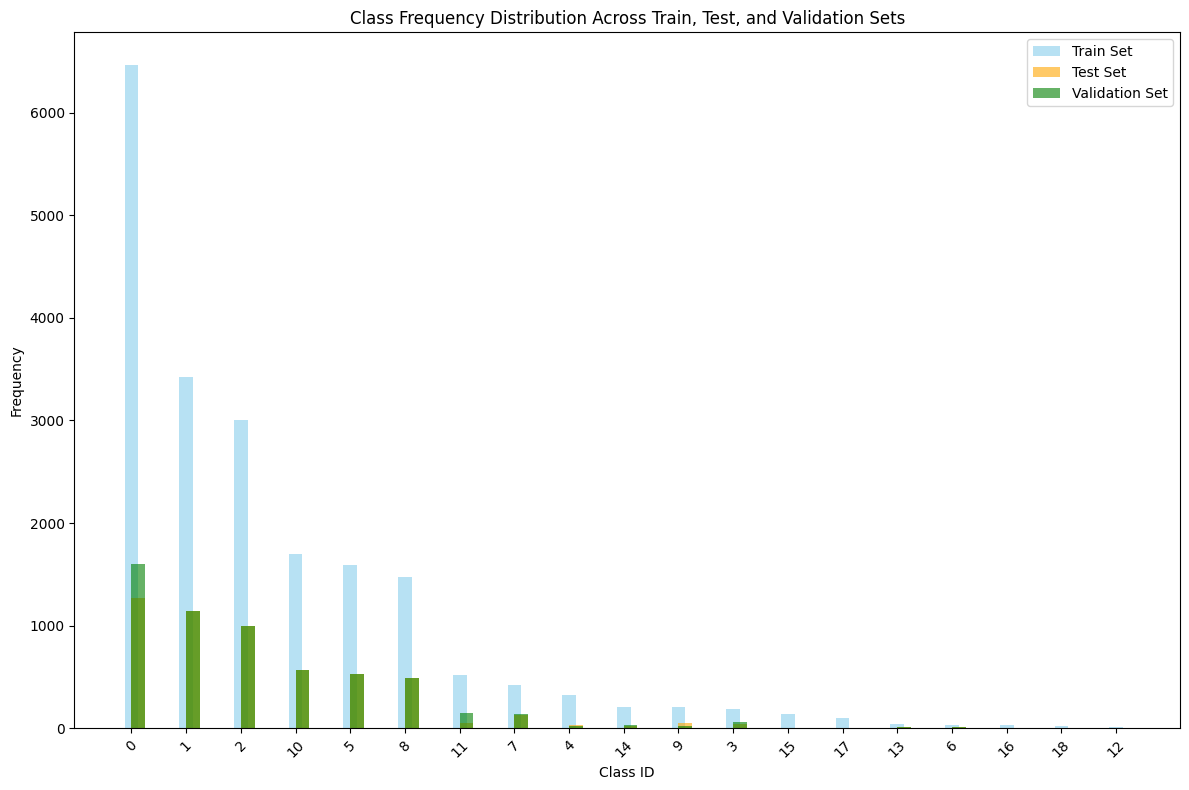

In [122]:
import matplotlib.pyplot as plt
from collections import Counter


# Function to count classes in a dataset and return a sorted list of class counts
def get_class_counts(dataset):
    all_classes = [cls for classes in dataset.values() for cls in classes]  # Flatten the list
    class_counts = Counter(all_classes)  # Count frequency of each class
    return class_counts.most_common()  # Sort by frequency in descending order

# Get sorted class counts for each dataset
train_class_counts = get_class_counts(train_set)
test_class_counts = get_class_counts(test_set)
val_class_counts = get_class_counts(val_set)

# Unzip the sorted counts into class ids and frequencies
train_class_ids, train_counts = zip(*train_class_counts)
test_class_ids, test_counts = zip(*test_class_counts)
val_class_ids, val_counts = zip(*val_class_counts)

# Create a single figure and axis
plt.figure(figsize=(12, 8))

# Plot each dataset with a different color
plt.bar(train_class_ids, train_counts, color='skyblue', label='Train Set', alpha=0.6, width=0.25, align='center')
plt.bar(test_class_ids, test_counts, color='orange', label='Test Set', alpha=0.6, width=0.25, align='edge')
plt.bar(val_class_ids, val_counts, color='green', label='Validation Set', alpha=0.6, width=0.25, align='edge')

# Add labels and title
plt.xlabel('Class ID')
plt.ylabel('Frequency')
plt.title('Class Frequency Distribution Across Train, Test, and Validation Sets')

# Add a legend to differentiate the sets
plt.legend()

# Optional: Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout for better fit
plt.tight_layout()

# Display the plot
plt.show()


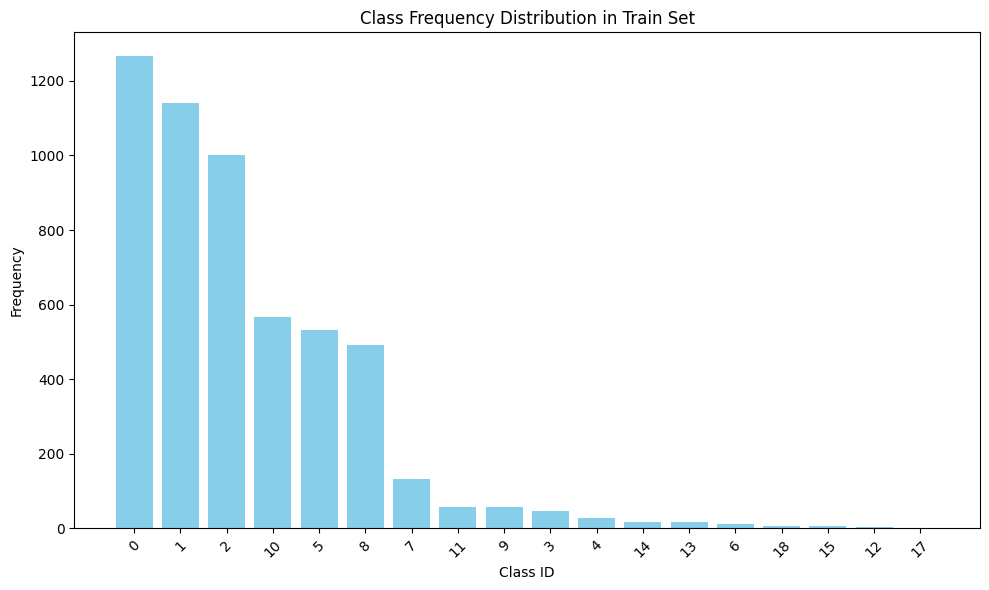

In [123]:
import matplotlib.pyplot as plt
from collections import Counter

# Sample train_set (replace this with your actual train_set)


# Step 1: Count the occurrences of each class in the train_set
all_classes = [cls for classes in test_set.values() for cls in classes]  # Flatten the list
class_counts = Counter(all_classes)  # Count frequency of each class

# Step 2: Sort the class counts in descending order by frequency
sorted_class_counts = class_counts.most_common()  # This returns a list of (class, count) tuples sorted by count

# Step 3: Prepare data for plotting
# Unzip the sorted list of tuples into two lists: class IDs and their counts
sorted_class_ids, sorted_counts = zip(*sorted_class_counts)

# Step 4: Plot the frequency of each class using a bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_class_ids, sorted_counts, color='skyblue')

# Add labels and title
plt.xlabel('Class ID')
plt.ylabel('Frequency')
plt.title('Class Frequency Distribution in Train Set')

# Optional: Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout for better fit
plt.show()



In [86]:
# Optional: Verify class distribution in the test set
test_class_distribution = Counter()
for classes in test_set.values():
    test_class_distribution.update(classes)

    # Optional: Verify class distribution in the test set
train_class_distribution = Counter()
for classes in train_set.values():
    train_class_distribution.update(classes)

# # Create a mapping from ID to name
id_to_name = {str(category['id'] - 1): category['name'] for category in categories}

# Replace numeric keys with category names
mapped_test_distribution = {id_to_name[k]: v for k, v in test_class_distribution.items() if k in id_to_name}

# Sort the mapped data by values in descending order
sorted_mapped_test_distribution = dict(sorted(mapped_test_distribution.items(), key=lambda item: item[1], reverse=True))

# Replace numeric keys with category names
mapped_train_distribution = {id_to_name[k]: v for k, v in train_class_distribution.items() if k in id_to_name}

# Sort the mapped data by values in descending order
sorted_mapped_train_distribution = dict(sorted(mapped_train_distribution.items(), key=lambda item: item[1], reverse=True))

# Ensure both dictionaries have the same keys in the same order
categories = list(sorted_mapped_train_distribution.keys())

test_values = [sorted_mapped_test_distribution.get(cat, 0) for cat in categories]
full_values = [sorted_mapped_train_distribution[cat] for cat in categories]

# Set up the plot
x = np.arange(len(categories))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))

bars1 = ax.barh(x - width/2, full_values, width, label='Train', color='lightblue')
bars2 = ax.barh(x + width/2, test_values, width, label='Test', color='salmon')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Count')
ax.set_title('Comparison of Class Distribution: Full Dataset vs Test Set')
ax.set_yticks(x)
ax.set_yticklabels(categories)
ax.legend()

# Add a grid for easier reading
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.savefig('../data/train_test.png')
plt.show()

TypeError: string indices must be integers

In [36]:
train_set = list(train_set.keys())
test_set = list(test_set.keys())

In [37]:
len(set(train_set))

3965

In [131]:
test_set = ['../data/dataset/images/'+i for i in test_set]
train_set = ['../data/dataset/images/'+i for i in train_set]
val_set = ['../data/dataset/images/'+i for i in val_set]

In [132]:
# Specify the filename
filename = '../data/dataset/test.txt'

# Open the file in write mode
with open(filename, 'w') as file:
    # Write each item to the file, followed by a newline
    for item in test_set:
        file.write(f"{item}\n")

In [40]:
# Calculate the number of items to select (20% of the list)
num_to_select = int(len(train_set) * val_percent)

# Select 20% of the items randomly
val_set = random.sample(train_set, num_to_select)

# Remove the selected items from the original list
for item in val_set:
    train_set.remove(item)

In [133]:
with open('../data/dataset/train.txt', 'w') as file :
    for item in train_set:
        file.write(f'{item}\n')
with open('../data/dataset/val.txt', 'w') as file :
    for item in val_set:
        file.write(f'{item}\n')

In [134]:

# Convert the lists to sets
train_set_set = set(train_set)
val_set_set = set(val_set)
test_set_set = set(test_set)

# Check for common items between train_set and val_set
common_train_val = train_set_set.intersection(val_set_set)
print(f"Common items between train_set and val_set: {common_train_val}")

# Check for common items between train_set and test_set
common_train_test = train_set_set.intersection(test_set_set)
print(f"Common items between train_set and test_set: {common_train_test}")

# Check for common items between val_set and test_set
common_val_test = val_set_set.intersection(test_set_set)
print(f"Common items between val_set and test_set: {common_val_test}")

# Check for common items across all three sets
common_all_sets = train_set_set.intersection(val_set_set, test_set_set)
print(f"Common items between all sets: {common_all_sets}")


Common items between train_set and val_set: set()
Common items between train_set and test_set: set()
Common items between val_set and test_set: set()
Common items between all sets: set()


In [135]:
len(train_set)

3016

In [136]:
len(val_set)

986

In [137]:
len(test_set)

860

In [138]:
len(os.listdir('../data/dataset/labels'))

4862

# Train model

In [3]:
from ultralytics import YOLO

# Load a model
#model = YOLO("yolo11n.yaml")  # build a new model from YAML
model = YOLO("../models/yolo11m.pt")  # load a pretrained model (recommended for training)
#model = YOLO("yolo11n.yaml").load("yolo11n.pt")  # build from YAML and transfer weights


In [4]:
len(list(model.model.modules()))

409

In [22]:
with open('yolo11n.txt', 'w') as f:
    f.write(str(model.model))

In [5]:
import torch

print("CUDA disponible:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No hay GPU")



CUDA disponible: True
GPU: Quadro P1000


In [ ]:
!nvidia-smi

Sat Nov  2 23:48:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 553.24                 Driver Version: 553.24         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro P1000                 WDDM  |   00000000:21:00.0  On |                  N/A |
| 34%   39C    P8             N/A /  N/A  |     420MiB /   4096MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#yolov11n run 7
from ultralytics import YOLO

# Load a model
model = YOLO("../models/yolo11n.pt")
results = model.train(data="data.yaml", 
                      epochs=100,
                      batch=8,
                      freeze=5,
                      lr0=0.01,
                      lrf=0.005, ##################3
                      verbose=True,
                      save_period=10,
                      save=True,
                      #pretrained='./runs/detect/yolo11n_models3/weights/best.pt',
                      name='yolo11n_runs',
                      plots=True,
                      device=0,
                      cache=False
                      )

Ultralytics 8.3.27  Python-3.10.4 torch-2.5.1+cu124 CUDA:0 (Quadro P1000, 4096MiB)
engine\trainer: task=detect, mode=train, model=../models/yolo11n.pt, data=data.yaml, epochs=100, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=8, project=None, name=yolo11n_runs7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=5, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

train: Scanning ..\data\dataset\labels... 3172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3172/3172 [07:48<00:00,  6.77it/s]

train: WARNING  ..\data\dataset\images\video1_frame_1341.png: 8 duplicate labels removed
train: WARNING  ..\data\dataset\images\video1_frame_13611.png: 14 duplicate labels removed
train: WARNING  ..\data\dataset\images\video1_frame_13631.png: 18 duplicate labels removed
train: WARNING  ..\data\dataset\images\video1_frame_13651.png: 16 duplicate labels removed
train: WARNING  ..\data\dataset\images\video1_frame_17526.png: 20 duplicate labels removed
train: WARNING  ..\data\dataset\images\video1_frame_17546.png: 18 duplicate labels removed
train: WARNING  ..\data\dataset\images\video1_frame_17586.png: 22 duplicate labels removed
train: WARNING  ..\data\dataset\images\video1_frame_17606.png: 20 duplicate labels removed
train: WARNING  ..\data\dataset\images\video1_frame_17626.png: 20 duplicate labels removed
train: WARNING  ..\data\dataset\images\video1_frame_17646.png: 14 duplicate labels removed
train: WARNING  ..\data\dataset\images\video1_frame_18786.png: 24 duplicate labels removed
t

train: New cache created: ..\data\dataset\labels.cache


val: Scanning ..\data\dataset\labels... 793 images, 0 backgrounds, 0 corrupt: 100%|██████████| 793/793 [02:07<00:00,  6.24it/s]

val: WARNING  ..\data\dataset\images\video1_frame_17566.png: 20 duplicate labels removed
val: WARNING  ..\data\dataset\images\video1_frame_18906.png: 16 duplicate labels removed
val: WARNING  ..\data\dataset\images\video1_frame_19006.png: 26 duplicate labels removed
val: WARNING  ..\data\dataset\images\video1_frame_19066.png: 22 duplicate labels removed
val: WARNING  ..\data\dataset\images\video1_frame_19146.png: 12 duplicate labels removed
val: WARNING  ..\data\dataset\images\video1_frame_19306.png: 24 duplicate labels removed
val: WARNING  ..\data\dataset\images\video1_frame_19346.png: 26 duplicate labels removed
val: WARNING  ..\data\dataset\images\video1_frame_2021.png: 12 duplicate labels removed
val: WARNING  ..\data\dataset\images\video1_frame_20261.png: 12 duplicate labels removed
val: WARNING  ..\data\dataset\images\video1_frame_2141.png: 16 duplicate labels removed
val: WARNING  ..\data\dataset\images\video1_frame_21821.png: 16 duplicate labels removed
val: WARNING  ..\data\d

Plotting labels to c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolo11n_runs7\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000435, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolo11n_runs7
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.908G      1.242      2.909      1.079         53        640: 100%|██████████| 397/397 [02:33<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


                   all        793       5026       0.85      0.233      0.246      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.956G      1.104      1.495      1.028         45        640: 100%|██████████| 397/397 [02:22<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


                   all        793       5026      0.786      0.272      0.318      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.975G      1.053      1.313       1.01         45        640: 100%|██████████| 397/397 [02:22<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:11<00:00,  4.48it/s]


                   all        793       5026      0.509      0.412      0.378      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.977G      1.027      1.193      1.003         33        640: 100%|██████████| 397/397 [02:22<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:11<00:00,  4.32it/s]


                   all        793       5026      0.615      0.494      0.499      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.984G     0.9898      1.101     0.9887         44        640: 100%|██████████| 397/397 [02:28<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


                   all        793       5026      0.622      0.499      0.526       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      0.95G     0.9675      1.044     0.9794         57        640: 100%|██████████| 397/397 [02:20<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.61it/s]


                   all        793       5026      0.739      0.509      0.579      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.969G     0.9439     0.9905     0.9698         25        640: 100%|██████████| 397/397 [02:14<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.64it/s]


                   all        793       5026      0.588      0.571      0.583      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.971G     0.9271     0.9439      0.965         34        640: 100%|██████████| 397/397 [02:12<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.80it/s]

                   all        793       5026      0.653      0.583      0.613      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.948G     0.9128     0.9011     0.9622         90        640: 100%|██████████| 397/397 [02:14<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.75it/s]


                   all        793       5026      0.821      0.582      0.659      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.971G     0.8954     0.8685      0.955         12        640: 100%|██████████| 397/397 [02:12<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.84it/s]


                   all        793       5026      0.763      0.602      0.644      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.975G     0.8898     0.8433     0.9504         43        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


                   all        793       5026      0.749      0.637      0.684      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.952G     0.8813     0.8098     0.9474         83        640: 100%|██████████| 397/397 [02:11<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026      0.771      0.623      0.672      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.948G       0.87     0.7924     0.9437         24        640: 100%|██████████| 397/397 [02:11<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.80it/s]

                   all        793       5026      0.766       0.63      0.697      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      0.95G     0.8629      0.777     0.9404         47        640: 100%|██████████| 397/397 [02:10<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.848      0.599      0.702       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      0.95G     0.8565     0.7571     0.9385         43        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.83it/s]

                   all        793       5026      0.838      0.619      0.726      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      0.95G     0.8523     0.7473     0.9394         34        640: 100%|██████████| 397/397 [02:11<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.81it/s]

                   all        793       5026      0.803      0.673       0.74      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.946G     0.8418     0.7304     0.9332         41        640: 100%|██████████| 397/397 [02:22<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


                   all        793       5026      0.809      0.679      0.759      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      0.95G      0.836      0.709     0.9324         41        640: 100%|██████████| 397/397 [02:11<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.84it/s]

                   all        793       5026      0.793      0.683      0.756      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.942G     0.8332     0.7052     0.9326         60        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.80it/s]

                   all        793       5026      0.788      0.702      0.759      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.979G      0.822     0.6877     0.9258         83        640: 100%|██████████| 397/397 [02:10<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.84it/s]

                   all        793       5026      0.767      0.712      0.769      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.954G     0.8228     0.6787     0.9272         38        640: 100%|██████████| 397/397 [02:10<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.83it/s]

                   all        793       5026       0.82      0.693      0.763      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.925G     0.8199     0.6725     0.9249         59        640: 100%|██████████| 397/397 [02:11<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.83it/s]

                   all        793       5026      0.846      0.704      0.788      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.946G     0.8163     0.6591     0.9248         47        640: 100%|██████████| 397/397 [02:10<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


                   all        793       5026      0.865      0.705      0.794      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.946G     0.8062     0.6464     0.9209         61        640: 100%|██████████| 397/397 [02:11<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.81it/s]

                   all        793       5026      0.849      0.692      0.779      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.944G     0.8012     0.6347     0.9191         40        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.87it/s]

                   all        793       5026      0.873      0.709      0.804      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.944G     0.8001      0.629      0.917         46        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.82it/s]

                   all        793       5026      0.887      0.706      0.809      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.952G     0.7944      0.613     0.9185         31        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026      0.825      0.737      0.791      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      0.96G     0.7901     0.6182     0.9144         76        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.858      0.748      0.815      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.979G     0.7885     0.6059     0.9156         63        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026      0.812      0.758      0.798      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.942G     0.7898     0.6019     0.9157         34        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.83it/s]

                   all        793       5026      0.835      0.771      0.817      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.979G     0.7781     0.5886     0.9118         60        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026      0.808      0.787      0.819      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      0.96G     0.7743     0.5848      0.912         49        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026        0.8      0.791      0.826      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.942G     0.7795     0.5788     0.9121         74        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026      0.834       0.79       0.83      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.977G     0.7707     0.5763     0.9113         35        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026      0.841      0.796      0.829      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.937G     0.7786     0.5742     0.9132         41        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.904      0.758      0.839      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.969G     0.7652     0.5658     0.9081         53        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.84it/s]

                   all        793       5026       0.88      0.786      0.851      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.942G     0.7636     0.5576     0.9072         25        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.875      0.775      0.839      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.956G      0.759     0.5529     0.9079         17        640: 100%|██████████| 397/397 [02:12<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.891      0.776      0.846      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.979G     0.7624     0.5507     0.9064         54        640: 100%|██████████| 397/397 [02:10<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.83it/s]

                   all        793       5026      0.875      0.814      0.855      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.979G     0.7552      0.544     0.9051         57        640: 100%|██████████| 397/397 [02:11<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.67it/s]

                   all        793       5026      0.869      0.801      0.852      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.971G     0.7529     0.5408     0.9032         71        640: 100%|██████████| 397/397 [02:12<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.904      0.805      0.861       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.969G     0.7523     0.5369     0.9047         28        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.878      0.802      0.856      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      0.94G     0.7443     0.5284     0.9015         41        640: 100%|██████████| 397/397 [02:11<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.84it/s]

                   all        793       5026      0.891      0.812      0.863      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.958G     0.7465     0.5254     0.9015         36        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.89it/s]

                   all        793       5026      0.902      0.805      0.863      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.967G     0.7416     0.5177     0.9037         24        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026      0.904      0.814       0.87      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.942G     0.7373     0.5157     0.8999         48        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.83it/s]

                   all        793       5026        0.9      0.813      0.858      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.944G     0.7391     0.5164     0.8994         30        640: 100%|██████████| 397/397 [02:10<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.81it/s]

                   all        793       5026      0.887      0.806      0.864      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.969G     0.7376     0.5117     0.9009         32        640: 100%|██████████| 397/397 [02:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:11<00:00,  4.48it/s]

                   all        793       5026       0.91      0.821      0.874      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.958G     0.7368     0.5136     0.8992         56        640: 100%|██████████| 397/397 [02:22<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:11<00:00,  4.46it/s]


                   all        793       5026      0.876      0.819      0.875      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.948G     0.7389     0.5108     0.8999         45        640: 100%|██████████| 397/397 [02:21<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:11<00:00,  4.48it/s]

                   all        793       5026      0.902      0.843      0.882      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.937G     0.7307     0.5041     0.8985         63        640: 100%|██████████| 397/397 [02:22<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:11<00:00,  4.49it/s]

                   all        793       5026       0.93      0.811       0.87      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.975G     0.7319     0.4985     0.8979         31        640: 100%|██████████| 397/397 [02:21<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:11<00:00,  4.47it/s]


                   all        793       5026      0.936      0.812      0.879      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.977G     0.7265     0.4934     0.8971         70        640: 100%|██████████| 397/397 [02:22<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


                   all        793       5026      0.905      0.818      0.869      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.979G       0.72     0.4924     0.8954         66        640: 100%|██████████| 397/397 [02:13<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.87it/s]

                   all        793       5026      0.906      0.816      0.871        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.969G      0.722     0.4845     0.8951         52        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.82it/s]

                   all        793       5026      0.912      0.828      0.878      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.948G     0.7191     0.4868     0.8919         53        640: 100%|██████████| 397/397 [02:13<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.84it/s]

                   all        793       5026       0.85      0.838      0.878      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.946G     0.7126     0.4814     0.8933         73        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026      0.912      0.843      0.883      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.946G     0.7174     0.4779      0.893         36        640: 100%|██████████| 397/397 [02:11<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.88it/s]

                   all        793       5026      0.911      0.833      0.876      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      0.94G     0.7127     0.4799     0.8921         45        640: 100%|██████████| 397/397 [02:11<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.87it/s]

                   all        793       5026      0.912      0.851      0.888      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.946G     0.7122     0.4765     0.8926         46        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026      0.914      0.827      0.884      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.944G     0.7165     0.4748     0.8933         35        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026      0.921      0.835      0.881      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.944G     0.7063     0.4715     0.8901         27        640: 100%|██████████| 397/397 [02:11<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.87it/s]

                   all        793       5026      0.913      0.848       0.88      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.981G     0.7038     0.4661     0.8917         39        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026       0.91      0.852      0.884      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.02G     0.7015     0.4639     0.8891         59        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026       0.94      0.827      0.888      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.946G     0.7029     0.4636     0.8893         38        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.83it/s]

                   all        793       5026      0.923      0.828      0.886      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.942G     0.6969     0.4589     0.8858         45        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.924      0.828      0.884      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.971G     0.6983     0.4567     0.8858         75        640: 100%|██████████| 397/397 [02:11<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.926      0.843      0.883      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.977G     0.6954     0.4517      0.886         48        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.925      0.847      0.892      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.946G     0.6911     0.4496     0.8854         46        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026      0.924      0.843      0.891      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.979G     0.6947     0.4535     0.8856         20        640: 100%|██████████| 397/397 [02:10<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.87it/s]

                   all        793       5026      0.919      0.841      0.888      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.958G       0.69     0.4478     0.8821         68        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026       0.85      0.869      0.891      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.942G     0.6868     0.4453      0.883         40        640: 100%|██████████| 397/397 [02:10<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026      0.932      0.845      0.888      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.946G     0.6871     0.4433     0.8837         39        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026       0.93      0.865      0.893      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.946G     0.6844     0.4413     0.8839         33        640: 100%|██████████| 397/397 [02:13<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.82it/s]

                   all        793       5026      0.946      0.838      0.898      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.933G     0.6827     0.4366     0.8841         58        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026      0.942      0.839      0.897      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.946G      0.682      0.436     0.8846         38        640: 100%|██████████| 397/397 [02:10<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.879      0.842      0.896      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.967G     0.6786     0.4338     0.8812         41        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.855       0.86      0.894      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.948G     0.6785     0.4369     0.8805         66        640: 100%|██████████| 397/397 [02:10<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026       0.87      0.861      0.897      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.979G     0.6791     0.4361     0.8813         40        640: 100%|██████████| 397/397 [02:10<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026      0.883      0.853        0.9       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.942G     0.6748     0.4306     0.8797         30        640: 100%|██████████| 397/397 [02:10<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.87it/s]

                   all        793       5026      0.937      0.857      0.901      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.967G     0.6723     0.4285     0.8806         37        640: 100%|██████████| 397/397 [02:11<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

                   all        793       5026      0.916      0.865      0.901      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.958G     0.6705      0.426     0.8786         53        640: 100%|██████████| 397/397 [02:10<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.84it/s]

                   all        793       5026      0.937      0.853      0.902      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      0.94G     0.6698     0.4246     0.8791         35        640: 100%|██████████| 397/397 [02:12<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.83it/s]

                   all        793       5026      0.928      0.864      0.902      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.942G     0.6718     0.4235     0.8787         53        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.934       0.86      0.904       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.948G     0.6671     0.4245      0.877         55        640: 100%|██████████| 397/397 [02:11<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.938      0.849      0.901      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.946G     0.6681     0.4243     0.8782         55        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.936      0.851      0.899      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.971G     0.6628     0.4179     0.8789         48        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.942      0.838      0.899      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.944G     0.6672     0.4184     0.8773         55        640: 100%|██████████| 397/397 [02:10<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.938      0.851        0.9      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.948G     0.6623     0.4169     0.8745         63        640: 100%|██████████| 397/397 [02:10<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.948      0.843        0.9       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.948G     0.6582      0.415     0.8764         62        640: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.85it/s]

                   all        793       5026      0.936      0.855        0.9      0.728


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      0.94G     0.6415      0.381     0.8638         24        640: 100%|██████████| 397/397 [02:07<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.82it/s]

                   all        793       5026      0.932      0.858      0.899      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.946G     0.6321     0.3721     0.8593         21        640: 100%|██████████| 397/397 [05:14<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:22<00:00,  2.25it/s]

                   all        793       5026       0.94      0.858        0.9      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.942G      0.626     0.3658     0.8611         25        640: 100%|██████████| 397/397 [05:15<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:22<00:00,  2.25it/s]

                   all        793       5026      0.952      0.851      0.898      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.946G     0.6283     0.3653     0.8619         23        640: 100%|██████████| 397/397 [05:15<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:22<00:00,  2.25it/s]

                   all        793       5026      0.944      0.849      0.898      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.948G      0.625     0.3652     0.8604         23        640: 100%|██████████| 397/397 [05:13<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:22<00:00,  2.23it/s]

                   all        793       5026      0.938       0.86      0.903       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.944G     0.6192     0.3597     0.8565         21        640: 100%|██████████| 397/397 [05:19<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:22<00:00,  2.22it/s]

                   all        793       5026      0.948      0.855      0.902      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.946G     0.6179     0.3575      0.857         25        640: 100%|██████████| 397/397 [05:19<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:22<00:00,  2.22it/s]

                   all        793       5026      0.947      0.851      0.902      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.946G     0.6135     0.3552     0.8549         18        640: 100%|██████████| 397/397 [05:19<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:22<00:00,  2.22it/s]

                   all        793       5026      0.941      0.858        0.9      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      0.95G     0.6175      0.357     0.8577         36        640: 100%|██████████| 397/397 [05:19<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:22<00:00,  2.22it/s]

                   all        793       5026      0.943      0.858        0.9      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.942G     0.6149     0.3555     0.8546         30        640: 100%|██████████| 397/397 [05:19<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:22<00:00,  2.22it/s]

                   all        793       5026      0.938      0.858      0.901      0.729



100 epochs completed in 4.506 hours.
Optimizer stripped from c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolo11n_runs7\weights\last.pt, 5.5MB
Optimizer stripped from c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolo11n_runs7\weights\best.pt, 5.5MB

Validating c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolo11n_runs7\weights\best.pt...
Ultralytics 8.3.27  Python-3.10.4 torch-2.5.1+cu124 CUDA:0 (Quadro P1000, 4096MiB)
YOLO11n summary (fused): 238 layers, 2,585,857 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:21<00:00,  2.29it/s]


                   all        793       5026      0.884      0.858      0.901      0.732
        1_Auto Privado        644       1567      0.914      0.932      0.963      0.799
                13_Bus        576        911      0.964      0.979      0.988      0.882
    11_Camioneta rural        525        771      0.966      0.955      0.989      0.855
           12_Microbus         55         57      0.912      0.905      0.933      0.786
            4_Mototaxi         47         50       0.87       0.92      0.937      0.652
         5_Moto lineal        319        400      0.912      0.853      0.941      0.679
9_Omnibus Interprovincial          6          6      0.916          1      0.995      0.927
     10_Auto colectivo         98        101       0.94      0.812      0.896      0.733
         14_Articulado        366        407      0.952      0.961      0.986      0.897
         2_Cam. PickUp         44         45      0.902      0.778      0.865      0.699
                3_

In [ ]:
#yolov11n run 12
from ultralytics import YOLO

# Load a model
model = YOLO("../models/yolo11n.pt")

results = model.train(data="data.yaml", 
                      epochs=200,
                      batch=16,
                      freeze=20,
                      lr0=0.01,
                      lrf=0.005, ##################3
                      verbose=True,
                      save_period=10,
                      save=True,
                      #pretrained='./runs/detect/yolo11n_models3/weights/best.pt',
                      name='yolo11n_runs',
                      plots=True,
                      device=0,
                      cache=False
                      )

Ultralytics 8.3.27  Python-3.10.4 torch-2.5.1+cu124 CUDA:0 (Quadro P1000, 4096MiB)
engine\trainer: task=detect, mode=train, model=../models/yolo11n.pt, data=data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=8, project=None, name=yolo11n_runs12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=20, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

train: Scanning ..\data\dataset\labels... 3172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3172/3172 [08:19<00:00,  6.35it/s]

train: WARNING  ..\data\dataset\images\video1_frame_9876.png: 1 duplicate labels removed


train: New cache created: ..\data\dataset\labels.cache


val: Scanning ..\data\dataset\labels... 793 images, 0 backgrounds, 0 corrupt: 100%|██████████| 793/793 [02:34<00:00,  5.14it/s]

val: WARNING  ..\data\dataset\images\video3_frame_28756.png: 1 duplicate labels removed
val: New cache created: ..\data\dataset\labels.cache


Plotting labels to c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolo11n_runs12\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000435, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolo11n_runs12
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200     0.954G      1.395      4.051      1.171         61        640: 100%|██████████| 199/199 [01:31<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]

                   all        793       5129      0.736      0.118      0.125     0.0814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200     0.967G      1.379      2.574      1.151         22        640: 100%|██████████| 199/199 [01:23<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.45it/s]

                   all        793       5129      0.728      0.179       0.18       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      0.99G      1.278      2.064      1.118         46        640: 100%|██████████| 199/199 [01:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.29it/s]

                   all        793       5129      0.642      0.231      0.239      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200     0.954G      1.245      1.881      1.104         25        640: 100%|██████████| 199/199 [01:27<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.40it/s]

                   all        793       5129      0.719      0.242      0.298      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      1.02G      1.216      1.769      1.096         66        640: 100%|██████████| 199/199 [01:38<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.22it/s]

                   all        793       5129      0.668       0.26      0.342      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200     0.994G      1.208      1.687      1.092         44        640: 100%|██████████| 199/199 [03:15<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]

                   all        793       5129      0.658      0.282      0.359      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200     0.965G      1.184      1.625      1.081         45        640: 100%|██████████| 199/199 [03:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.25it/s]

                   all        793       5129        0.4      0.406      0.365      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200     0.956G      1.172      1.571      1.076         27        640: 100%|██████████| 199/199 [03:13<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129      0.583      0.336      0.389      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      1.03G      1.161      1.528       1.07         38        640: 100%|██████████| 199/199 [03:14<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]

                   all        793       5129      0.458      0.374      0.389      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200     0.981G       1.15      1.495      1.064         45        640: 100%|██████████| 199/199 [01:44<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]

                   all        793       5129      0.485        0.4      0.417      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200     0.946G      1.147      1.458       1.06         48        640: 100%|██████████| 199/199 [03:15<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.25it/s]


                   all        793       5129      0.423      0.418      0.391      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200     0.975G      1.145      1.438      1.058         72        640: 100%|██████████| 199/199 [03:14<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]

                   all        793       5129      0.549      0.432      0.431      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200     0.994G       1.13      1.402      1.052         26        640: 100%|██████████| 199/199 [03:13<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.25it/s]

                   all        793       5129      0.535      0.435      0.453      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200     0.984G      1.126      1.379       1.05         27        640: 100%|██████████| 199/199 [03:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129      0.447      0.475      0.448      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200     0.952G      1.122      1.365       1.05         49        640: 100%|██████████| 199/199 [03:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]

                   all        793       5129       0.58      0.417      0.458      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200     0.981G      1.118      1.351      1.049         32        640: 100%|██████████| 199/199 [03:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]

                   all        793       5129      0.495       0.45      0.465      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200     0.954G      1.114      1.336      1.045         33        640: 100%|██████████| 199/199 [03:14<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]

                   all        793       5129      0.468      0.466      0.458      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200     0.969G      1.112      1.324      1.045         46        640: 100%|██████████| 199/199 [03:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]

                   all        793       5129      0.535       0.43      0.472      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200     0.973G      1.104      1.307      1.041         54        640: 100%|██████████| 199/199 [03:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129        0.5      0.481      0.479      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200         1G      1.106      1.289      1.038         59        640: 100%|██████████| 199/199 [03:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]

                   all        793       5129      0.559      0.461      0.484      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200     0.946G      1.099      1.283      1.039         24        640: 100%|██████████| 199/199 [03:14<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129      0.588      0.421      0.482      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200     0.935G       1.09      1.256      1.034         54        640: 100%|██████████| 199/199 [03:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:17<00:00,  1.41it/s]

                   all        793       5129      0.605      0.454      0.497      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      1.05G      1.094      1.261      1.036         42        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]

                   all        793       5129      0.577      0.446       0.49      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200     0.952G      1.094      1.255      1.034         57        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]

                   all        793       5129      0.546      0.443      0.493      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200     0.944G      1.091      1.246      1.036         34        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]

                   all        793       5129      0.658      0.435      0.503      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      1.03G      1.082      1.229       1.03         64        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]

                   all        793       5129      0.639      0.467      0.508      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200     0.986G      1.086      1.237      1.029         33        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]

                   all        793       5129      0.605      0.469      0.519       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200     0.952G      1.086      1.228       1.03         80        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.25it/s]

                   all        793       5129      0.593      0.475      0.509      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200     0.942G      1.079      1.217      1.031         51        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]

                   all        793       5129      0.655      0.461      0.519      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200     0.975G       1.08      1.215      1.029         40        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]

                   all        793       5129      0.655      0.447      0.514      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200     0.984G      1.076      1.207      1.026         57        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]

                   all        793       5129      0.597      0.474      0.529      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200     0.992G      1.067      1.196      1.023         48        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]

                   all        793       5129      0.684      0.473      0.535      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      1.07G      1.072      1.199      1.026         37        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]

                   all        793       5129      0.568      0.485      0.533      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200     0.996G      1.071      1.186      1.027         71        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129      0.577      0.491      0.544      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200     0.956G      1.072      1.184      1.022         44        640: 100%|██████████| 199/199 [03:12<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]

                   all        793       5129      0.665      0.479      0.554      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      0.94G      1.065      1.179       1.02         59        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129       0.49      0.566      0.555       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      1.07G      1.063      1.169       1.02         54        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129      0.644      0.485      0.553      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200     0.958G      1.063      1.177       1.02         54        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]

                   all        793       5129      0.586      0.499      0.544      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200     0.952G      1.058      1.172      1.016         38        640: 100%|██████████| 199/199 [03:12<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]

                   all        793       5129      0.531      0.512      0.542       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      1.05G       1.06      1.165      1.022         49        640: 100%|██████████| 199/199 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129      0.738      0.444      0.548      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200     0.979G      1.055      1.156      1.017         51        640: 100%|██████████| 199/199 [02:29<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]

                   all        793       5129      0.642      0.475      0.557      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      0.96G      1.064      1.163      1.019         69        640: 100%|██████████| 199/199 [03:15<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129      0.678      0.465      0.559      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      0.95G      1.054      1.157      1.017         26        640: 100%|██████████| 199/199 [03:15<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129      0.669      0.467      0.565      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200     0.948G      1.055      1.147      1.016         35        640: 100%|██████████| 199/199 [03:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129      0.619       0.48      0.559      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      1.04G      1.052      1.146      1.021         40        640: 100%|██████████| 199/199 [03:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129      0.603      0.523      0.572      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200     0.958G      1.042      1.135      1.012         61        640: 100%|██████████| 199/199 [03:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129      0.683      0.475      0.568       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200     0.954G      1.052      1.141      1.015         37        640: 100%|██████████| 199/199 [03:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129      0.615      0.506      0.575      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      1.02G      1.047      1.134      1.013         39        640: 100%|██████████| 199/199 [03:15<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.25it/s]

                   all        793       5129      0.584      0.548      0.586      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      1.05G      1.046       1.13      1.011         52        640: 100%|██████████| 199/199 [03:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]

                   all        793       5129      0.588      0.564      0.592      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200     0.988G      1.047      1.137      1.016         24        640: 100%|██████████| 199/199 [03:15<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]

                   all        793       5129       0.68      0.504      0.586      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200     0.981G      1.047      1.132      1.016         31        640: 100%|██████████| 199/199 [03:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]

                   all        793       5129      0.578      0.575      0.598      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200     0.965G      1.045      1.122      1.012         41        640: 100%|██████████| 199/199 [03:15<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129      0.638       0.53      0.568      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200     0.994G      1.036      1.116      1.009         60        640: 100%|██████████| 199/199 [03:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]

                   all        793       5129       0.59      0.543      0.581      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200     0.984G      1.042      1.126       1.01         54        640: 100%|██████████| 199/199 [03:14<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.27it/s]

                   all        793       5129      0.556      0.566       0.58      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      1.07G      1.036      1.112      1.009         19        640: 100%|██████████| 199/199 [03:15<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129      0.622      0.559      0.581      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200     0.935G      1.046      1.117      1.009         66        640: 100%|██████████| 199/199 [03:12<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]

                   all        793       5129      0.612      0.558      0.596      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200     0.994G      1.034      1.109      1.008         38        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]

                   all        793       5129      0.654      0.527      0.593      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      1.02G      1.038      1.112      1.008         56        640: 100%|██████████| 199/199 [03:15<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]

                   all        793       5129      0.588      0.576       0.59      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200     0.944G      1.034      1.108      1.009         51        640: 100%|██████████| 199/199 [03:16<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]

                   all        793       5129      0.643      0.562        0.6      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      1.03G      1.034      1.107       1.01         50        640: 100%|██████████| 199/199 [03:15<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129       0.68      0.545        0.6      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200     0.931G      1.034      1.102      1.007         38        640: 100%|██████████| 199/199 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]

                   all        793       5129      0.657      0.541        0.6      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200     0.971G      1.034      1.102      1.009         55        640: 100%|██████████| 199/199 [03:07<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]

                   all        793       5129      0.646      0.556      0.607      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      1.02G      1.023      1.097      1.006         42        640: 100%|██████████| 199/199 [01:23<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]

                   all        793       5129      0.711      0.502        0.6      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200     0.927G      1.036      1.104      1.008         36        640: 100%|██████████| 199/199 [01:24<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.43it/s]

                   all        793       5129      0.705      0.489      0.597      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200     0.937G      1.028      1.101      1.006         53        640: 100%|██████████| 199/199 [01:24<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.38it/s]

                   all        793       5129      0.704      0.499      0.606      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200     0.942G      1.031      1.094      1.005         50        640: 100%|██████████| 199/199 [01:23<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]

                   all        793       5129      0.596      0.577      0.605      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200     0.935G      1.026      1.088      1.004         38        640: 100%|██████████| 199/199 [01:24<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]

                   all        793       5129      0.645      0.541      0.602      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200     0.925G      1.027      1.086      1.003         44        640: 100%|██████████| 199/199 [01:26<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.45it/s]

                   all        793       5129      0.704      0.536      0.609       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200     0.921G      1.025      1.085      1.005         49        640: 100%|██████████| 199/199 [01:26<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.34it/s]

                   all        793       5129      0.621      0.563      0.612      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      1.04G      1.032      1.085      1.005         28        640: 100%|██████████| 199/199 [01:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.34it/s]

                   all        793       5129      0.679      0.542      0.605      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200     0.942G       1.03      1.091      1.003         51        640: 100%|██████████| 199/199 [01:26<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.33it/s]

                   all        793       5129      0.705       0.54       0.62      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200     0.963G      1.024      1.082          1         50        640: 100%|██████████| 199/199 [01:25<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.45it/s]

                   all        793       5129      0.686      0.559      0.623      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200     0.973G      1.028      1.085      1.003         27        640: 100%|██████████| 199/199 [01:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]

                   all        793       5129      0.595      0.598      0.619      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200     0.948G      1.018      1.071     0.9993         58        640: 100%|██████████| 199/199 [01:24<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.40it/s]

                   all        793       5129      0.669      0.537      0.617      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200     0.992G       1.02      1.075      1.001         52        640: 100%|██████████| 199/199 [01:27<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.36it/s]

                   all        793       5129      0.658      0.558      0.624       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      0.95G      1.023       1.08      1.002         28        640: 100%|██████████| 199/199 [01:24<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]

                   all        793       5129      0.626      0.588      0.621      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200     0.971G      1.018       1.07          1         30        640: 100%|██████████| 199/199 [01:20<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.649      0.571      0.621      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200     0.935G      1.023      1.073      1.001         38        640: 100%|██████████| 199/199 [01:20<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        793       5129      0.662      0.579      0.634      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      1.07G      1.025      1.075      0.999         46        640: 100%|██████████| 199/199 [01:20<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]

                   all        793       5129      0.634      0.606      0.629      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200     0.954G      1.016      1.068     0.9967         35        640: 100%|██████████| 199/199 [01:22<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]

                   all        793       5129      0.606      0.603      0.622      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      1.03G      1.017      1.063      1.002         48        640: 100%|██████████| 199/199 [01:21<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        793       5129      0.578       0.61      0.619      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      1.07G      1.023      1.064     0.9975         43        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]

                   all        793       5129      0.643      0.585      0.621      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200         1G      1.013      1.065     0.9987         44        640: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.647      0.594      0.622       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200     0.994G      1.016      1.063     0.9989         44        640: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]

                   all        793       5129      0.636      0.586      0.626      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200     0.958G       1.02      1.066     0.9979         50        640: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]

                   all        793       5129      0.638      0.595      0.623      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200     0.977G      1.012       1.06     0.9962         41        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]

                   all        793       5129      0.632      0.597      0.637      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      0.99G      1.013       1.06     0.9981         46        640: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.681      0.572      0.633      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200     0.948G       1.01      1.056     0.9967         57        640: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.628      0.587      0.632      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200     0.986G      1.018      1.066     0.9975         52        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.661      0.568      0.631      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      1.07G      1.014      1.054     0.9966         48        640: 100%|██████████| 199/199 [01:20<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.595        0.6      0.634      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200     0.944G       1.01      1.061      0.997         31        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.754      0.504      0.621      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200     0.988G      1.011      1.056     0.9949         43        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.614      0.618      0.624      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      0.96G      1.016      1.054     0.9974         66        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]

                   all        793       5129      0.637      0.603      0.638      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200     0.963G      1.014      1.059     0.9942         45        640: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]

                   all        793       5129      0.659      0.576      0.633      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200     0.973G      1.008      1.047     0.9951         48        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]

                   all        793       5129      0.667      0.564      0.627      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200     0.946G      1.013      1.054     0.9946         52        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        793       5129      0.628      0.615      0.645      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200     0.981G      1.012      1.052     0.9948         47        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        793       5129      0.645      0.622      0.647      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      1.01G      1.015      1.045      0.997         66        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.684      0.589      0.651      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      1.03G      1.007      1.041     0.9934         45        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]

                   all        793       5129      0.677      0.585      0.647      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200     0.944G     0.9998       1.04      0.992         41        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]

                   all        793       5129      0.668      0.604      0.646      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200     0.948G      1.007      1.046     0.9945         66        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]

                   all        793       5129      0.643      0.608      0.645       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200     0.977G      1.003      1.039     0.9899         61        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.641      0.612      0.645      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200     0.971G      1.005      1.044     0.9928         56        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129       0.67      0.605      0.654      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      1.04G      1.007      1.049     0.9948         49        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        793       5129       0.67      0.588      0.638      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200     0.946G      1.003       1.04      0.991         65        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.661       0.59      0.634      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      0.96G     0.9994      1.036     0.9944         32        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.637      0.599      0.638      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      0.94G      1.007      1.044     0.9931         42        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]

                   all        793       5129      0.626       0.62      0.641      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200     0.998G          1       1.03     0.9901         27        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.648      0.594      0.643      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      0.94G      1.003      1.033     0.9912         40        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]

                   all        793       5129      0.665      0.589      0.643      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200     0.975G     0.9997      1.033     0.9898         45        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.743      0.558      0.647      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200     0.992G     0.9987      1.034     0.9883         54        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]

                   all        793       5129      0.687      0.587      0.649      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      1.07G      1.002      1.036     0.9905         33        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]

                   all        793       5129      0.691      0.586      0.647      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      1.02G      1.002      1.034     0.9918         37        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.718      0.592      0.652      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200     0.969G     0.9992      1.026     0.9913         19        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]

                   all        793       5129       0.73      0.568       0.65       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200     0.967G     0.9959      1.022     0.9907         42        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.653      0.601      0.646       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      1.03G     0.9955      1.023     0.9896         49        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.718      0.582      0.655      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      1.02G      0.997      1.035     0.9921         35        640: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.666       0.61      0.658      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      1.03G     0.9928      1.023     0.9889         37        640: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]

                   all        793       5129      0.715      0.575      0.651       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200     0.969G     0.9944      1.031      0.987         59        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]

                   all        793       5129      0.644      0.591      0.648      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200     0.979G     0.9993      1.029     0.9915         45        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]

                   all        793       5129      0.648      0.602      0.647      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      0.99G     0.9925      1.022     0.9879         43        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.653      0.607      0.649       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      0.99G      0.997      1.026     0.9907         53        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.649      0.615      0.643      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200     0.942G     0.9997      1.025     0.9905         23        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]

                   all        793       5129      0.667      0.594      0.648      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      0.94G          1      1.027      0.989         28        640: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]

                   all        793       5129      0.637      0.606      0.651      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      1.07G     0.9976      1.018     0.9892         32        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129       0.66      0.595      0.651      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200     0.931G     0.9958      1.021     0.9882         54        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.72it/s]

                   all        793       5129      0.635      0.618      0.647      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200     0.965G     0.9987      1.027     0.9907         34        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.692      0.605       0.65      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200     0.975G     0.9917      1.018     0.9864         39        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]

                   all        793       5129       0.66      0.622      0.658      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200     0.986G     0.9934      1.023     0.9867         35        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]

                   all        793       5129      0.734      0.557      0.656      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200     0.935G     0.9945      1.019     0.9868         27        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.661      0.594      0.647       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      1.08G     0.9966       1.02     0.9885         51        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.646      0.615      0.653      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200     0.975G     0.9946       1.02     0.9894         41        640: 100%|██████████| 199/199 [01:20<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        793       5129      0.672       0.61      0.657      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      1.05G     0.9931      1.026     0.9869         27        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]

                   all        793       5129      0.667      0.592      0.651      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      1.02G     0.9939      1.018     0.9859         42        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]

                   all        793       5129      0.643      0.603      0.651      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      1.06G     0.9943      1.016     0.9872         65        640: 100%|██████████| 199/199 [01:20<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]

                   all        793       5129       0.66      0.595       0.65      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200     0.937G     0.9945      1.012     0.9891         43        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.666      0.621      0.655      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200     0.937G     0.9933      1.016     0.9875         29        640: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.687      0.612      0.664      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200     0.971G     0.9864      1.007     0.9872         37        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]

                   all        793       5129      0.718      0.593      0.663      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200     0.963G     0.9917      1.012     0.9865         51        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.668      0.621      0.663      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      1.07G     0.9909       1.02     0.9847         50        640: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]

                   all        793       5129      0.716      0.596      0.658      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200     0.929G     0.9881      1.008     0.9848         45        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]

                   all        793       5129      0.715      0.608      0.666      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200     0.944G     0.9887      1.012     0.9839         51        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        793       5129      0.764       0.57       0.66      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      1.02G      0.982      1.001     0.9837         50        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.704      0.604      0.661      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200     0.942G     0.9923      1.012     0.9888         46        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129       0.68      0.616      0.665      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      1.03G     0.9853      1.008     0.9857         45        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        793       5129      0.769       0.58      0.672      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      0.95G     0.9895      1.011     0.9873         24        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.709      0.603      0.671      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200     0.956G     0.9839      1.006      0.984         56        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.687       0.61      0.671      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200     0.963G     0.9825      1.002     0.9857         69        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.749      0.596      0.663      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200     0.975G     0.9832      1.004     0.9844         50        640: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]

                   all        793       5129      0.734      0.594      0.661      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200     0.971G     0.9861      1.008     0.9845         42        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]

                   all        793       5129       0.74      0.586      0.668      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      1.03G     0.9902      1.008     0.9862         51        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]

                   all        793       5129       0.72        0.6      0.667      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200     0.937G       0.98      1.004     0.9813         26        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]

                   all        793       5129      0.687        0.6      0.664      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200     0.992G     0.9847      1.003     0.9801         45        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.799      0.558      0.669        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      1.04G     0.9794      1.002     0.9809         30        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        793       5129      0.692       0.61      0.669      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200     0.948G     0.9826     0.9977     0.9819         22        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.681      0.608      0.667      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200     0.942G     0.9774     0.9949     0.9811         33        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.655      0.629       0.65      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      0.99G      0.985      1.001     0.9844         28        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]

                   all        793       5129      0.655      0.626      0.663      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      0.94G     0.9809     0.9951     0.9837         38        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        793       5129      0.652      0.615      0.661      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200     0.996G     0.9807     0.9955     0.9828         42        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.659      0.626      0.664      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200     0.931G     0.9827      1.005     0.9836         24        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.662      0.631      0.667      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200     0.984G     0.9797     0.9979     0.9825         54        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]

                   all        793       5129      0.671      0.617      0.666      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200     0.975G     0.9776     0.9954     0.9819         34        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]

                   all        793       5129      0.639      0.627      0.664      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200     0.973G     0.9824     0.9961     0.9834         35        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        793       5129      0.654      0.632      0.666      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200     0.963G     0.9781     0.9939     0.9805         41        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.678      0.621      0.668      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      0.94G     0.9762     0.9908     0.9816         39        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]

                   all        793       5129      0.651      0.632      0.663      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      1.05G      0.983     0.9992     0.9814         44        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]

                   all        793       5129      0.647      0.617      0.661      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      1.05G     0.9765     0.9927     0.9802         52        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]

                   all        793       5129      0.651       0.63      0.664      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      1.06G     0.9779     0.9944      0.979         39        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]

                   all        793       5129      0.637      0.646      0.665      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      1.07G     0.9839     0.9973     0.9807         56        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]

                   all        793       5129      0.696      0.596      0.671      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      1.03G     0.9722     0.9908     0.9803         63        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.685      0.628      0.671      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200     0.933G     0.9755     0.9986     0.9814         30        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]

                   all        793       5129      0.681      0.612      0.669        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200     0.971G     0.9702     0.9939     0.9774         46        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]

                   all        793       5129      0.678       0.61      0.669      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      1.06G     0.9767      0.996     0.9794         60        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]

                   all        793       5129      0.694      0.617      0.672      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200     0.929G      0.976     0.9904     0.9786         37        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]

                   all        793       5129      0.674      0.629       0.67      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200     0.996G     0.9772     0.9964      0.982         51        640: 100%|██████████| 199/199 [01:19<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]

                   all        793       5129      0.676      0.623      0.669      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200     0.975G     0.9737     0.9925     0.9802         49        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        793       5129      0.698      0.621      0.671      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      1.08G     0.9708     0.9888     0.9786         32        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129        0.7      0.624      0.671      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200     0.952G     0.9736     0.9833     0.9788         27        640: 100%|██████████| 199/199 [01:20<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]

                   all        793       5129      0.704      0.623       0.67      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      1.03G     0.9712     0.9916     0.9792         37        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]

                   all        793       5129      0.695      0.617      0.669      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200     0.979G     0.9697     0.9843      0.979         52        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.712      0.601      0.673      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200     0.977G     0.9731     0.9881     0.9781         33        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.72it/s]

                   all        793       5129      0.703      0.606      0.673      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      1.02G     0.9691     0.9847     0.9774         46        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.685      0.619      0.674      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200     0.937G     0.9729     0.9835     0.9783         35        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        793       5129       0.71      0.603      0.676      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200     0.984G     0.9689       0.98     0.9766         37        640: 100%|██████████| 199/199 [01:20<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]

                   all        793       5129      0.705      0.603      0.675      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200     0.986G     0.9675     0.9865     0.9783         33        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]

                   all        793       5129      0.703      0.608      0.676      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      0.96G     0.9725     0.9883     0.9799         38        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129      0.717      0.606      0.676      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200     0.954G     0.9754     0.9924     0.9806         51        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.715      0.608      0.677      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200     0.963G     0.9686     0.9855     0.9777         47        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]

                   all        793       5129      0.715      0.607      0.677      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200     0.977G     0.9664     0.9883     0.9773         42        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]

                   all        793       5129      0.708      0.611      0.678      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200     0.967G     0.9692     0.9825     0.9792         20        640: 100%|██████████| 199/199 [01:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129      0.711      0.607      0.678      0.507


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200     0.946G     0.9671     0.9995     0.9776         24        640: 100%|██████████| 199/199 [01:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]

                   all        793       5129      0.702      0.605      0.667      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200     0.967G     0.9562     0.9671     0.9764         20        640: 100%|██████████| 199/199 [01:17<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129       0.69      0.595      0.653      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200     0.908G     0.9509     0.9547     0.9735         22        640: 100%|██████████| 199/199 [01:17<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        793       5129      0.655      0.604      0.644      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200     0.946G     0.9499     0.9607     0.9739         20        640: 100%|██████████| 199/199 [01:17<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        793       5129      0.654      0.593      0.641      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200     0.946G     0.9577      0.962      0.974         30        640: 100%|██████████| 199/199 [01:17<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.62it/s]

                   all        793       5129      0.647      0.593      0.629      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200     0.948G     0.9483     0.9492     0.9713         33        640: 100%|██████████| 199/199 [01:17<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]

                   all        793       5129       0.65      0.595      0.627       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200     0.946G     0.9493     0.9449     0.9718         22        640: 100%|██████████| 199/199 [01:17<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]

                   all        793       5129      0.651      0.595      0.625       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200     0.967G     0.9487     0.9499     0.9756         25        640: 100%|██████████| 199/199 [01:17<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]

                   all        793       5129      0.645      0.597      0.625       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      0.87G     0.9491      0.948     0.9728         25        640: 100%|██████████| 199/199 [01:17<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.62it/s]

                   all        793       5129      0.644      0.593      0.624       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200     0.967G      0.946      0.946      0.971         22        640: 100%|██████████| 199/199 [01:17<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]

                   all        793       5129       0.64      0.596      0.625      0.459



200 epochs completed in 6.987 hours.
Optimizer stripped from c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolo11n_runs12\weights\last.pt, 5.5MB
Optimizer stripped from c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolo11n_runs12\weights\best.pt, 5.5MB

Validating c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolo11n_runs12\weights\best.pt...
Ultralytics 8.3.27  Python-3.10.4 torch-2.5.1+cu124 CUDA:0 (Quadro P1000, 4096MiB)
YOLO11n summary (fused): 238 layers, 2,585,857 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:10<00:00,  2.31it/s]


                   all        793       5129      0.737      0.596      0.677      0.505
        1_Auto Privado        653       1648      0.708      0.749      0.775      0.578
                13_Bus        562        895      0.778      0.947      0.951      0.753
    11_Camioneta rural        529        797      0.791      0.827      0.889      0.675
           12_Microbus         42         44      0.721      0.704      0.755      0.616
            4_Mototaxi         61         66      0.756       0.53       0.63      0.355
         5_Moto lineal        330        407      0.763      0.619      0.692      0.404
9_Omnibus Interprovincial         13         13      0.977      0.769      0.811      0.696
     10_Auto colectivo        109        113       0.55      0.177       0.32      0.227
         14_Articulado        371        407      0.883      0.872      0.934      0.808
         2_Cam. PickUp         46         49      0.725      0.216      0.335      0.246
                3_

In [ ]:
#yolov11m runs 13
from ultralytics import YOLO

# Load a model
model = YOLO("../models/yolo11m.pt")

results = model.train(data="data.yaml", 
                      epochs=300,
                      batch=16,
                      freeze=20,
                      lr0=0.01,
                      lrf=0.005, ##################3
                      verbose=True,
                      save_period=10,
                      save=True,
                      #pretrained='./runs/detect/yolo11n_models3/weights/best.pt',
                      name='yolo11n_runs',
                      plots=True,
                      device=0,
                      cache=False
                      )

# duros dos dias 

Ultralytics 8.3.27  Python-3.10.4 torch-2.5.1+cu124 CUDA:0 (Quadro P1000, 4096MiB)
engine\trainer: task=detect, mode=train, model=../models/yolo11m.pt, data=data.yaml, epochs=300, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=8, project=None, name=yolo11n_runs13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=20, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

train: Scanning ..\data\dataset\labels... 3172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3172/3172 [01:22<00:00, 38.65it/s]

train: WARNING  ..\data\dataset\images\video1_frame_9876.png: 1 duplicate labels removed


train: New cache created: ..\data\dataset\labels.cache


val: Scanning ..\data\dataset\labels... 793 images, 0 backgrounds, 0 corrupt: 100%|██████████| 793/793 [00:10<00:00, 72.48it/s]

val: WARNING  ..\data\dataset\images\video3_frame_28756.png: 1 duplicate labels removed


val: New cache created: ..\data\dataset\labels.cache
Plotting labels to c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolo11n_runs13\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolo11n_runs13
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.18G      1.162      1.908      1.148         61        640: 100%|██████████| 199/199 [05:34<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:42<00:00,  1.68s/it]


                   all        793       5129      0.633      0.318      0.319       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      2.13G      1.103      1.346      1.095         22        640: 100%|██████████| 199/199 [05:31<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:40<00:00,  1.64s/it]

                   all        793       5129      0.697      0.373      0.474      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300       2.1G      1.098      1.279      1.092         46        640: 100%|██████████| 199/199 [05:31<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:40<00:00,  1.63s/it]

                   all        793       5129      0.555      0.502      0.507      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300       2.1G      1.098      1.192      1.092         25        640: 100%|██████████| 199/199 [05:32<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:41<00:00,  1.65s/it]

                   all        793       5129      0.683      0.533      0.563      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      1.98G      1.072      1.112      1.086         66        640: 100%|██████████| 199/199 [05:29<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:40<00:00,  1.63s/it]

                   all        793       5129      0.669       0.53      0.587      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      2.12G       1.06       1.07      1.079         44        640: 100%|██████████| 199/199 [05:27<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:39<00:00,  1.59s/it]

                   all        793       5129      0.589       0.57      0.595      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.11G      1.043      1.027      1.072         45        640: 100%|██████████| 199/199 [05:11<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:38<00:00,  1.53s/it]

                   all        793       5129      0.669      0.536      0.565      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300         2G      1.034      1.006      1.069         27        640: 100%|██████████| 199/199 [05:06<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]

                   all        793       5129       0.64       0.57      0.603      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300         2G      1.022     0.9897      1.063         38        640: 100%|██████████| 199/199 [05:06<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.48s/it]

                   all        793       5129       0.62      0.539       0.61      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.03G      1.017     0.9726      1.056         45        640: 100%|██████████| 199/199 [05:03<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.612      0.611      0.659      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      1.98G      1.006     0.9505      1.052         48        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.604      0.609      0.618      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.15G      1.012     0.9412      1.053         72        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.696      0.547      0.656      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.12G     0.9955     0.9261      1.045         26        640: 100%|██████████| 199/199 [05:01<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.639      0.584      0.614      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      1.96G     0.9934     0.9176      1.046         27        640: 100%|██████████| 199/199 [05:01<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.49s/it]

                   all        793       5129      0.712      0.521      0.645      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.14G     0.9874     0.9106      1.043         49        640: 100%|██████████| 199/199 [05:00<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129       0.69      0.593      0.646      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.12G     0.9846      0.906      1.045         32        640: 100%|██████████| 199/199 [05:01<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]

                   all        793       5129      0.625      0.656       0.68      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.04G     0.9814     0.8972       1.04         33        640: 100%|██████████| 199/199 [04:49<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]

                   all        793       5129      0.667      0.615      0.666      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.12G     0.9809     0.8854      1.042         46        640: 100%|██████████| 199/199 [04:51<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.48s/it]

                   all        793       5129      0.699      0.567      0.677      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      1.98G      0.977     0.8819      1.039         54        640: 100%|██████████| 199/199 [04:55<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129       0.71      0.598      0.691      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.01G     0.9736      0.876      1.035         59        640: 100%|██████████| 199/199 [04:51<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]

                   all        793       5129      0.681      0.674      0.715      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.01G     0.9676     0.8638      1.034         24        640: 100%|██████████| 199/199 [04:53<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129      0.699      0.628      0.714      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.06G     0.9595     0.8546      1.029         54        640: 100%|██████████| 199/199 [04:51<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129      0.663      0.678      0.709      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      1.98G     0.9635     0.8554      1.029         42        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129      0.707       0.63      0.675      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.15G     0.9631     0.8526       1.03         57        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]

                   all        793       5129      0.653      0.676      0.703      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      1.98G     0.9605     0.8477      1.032         34        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129      0.718      0.641      0.711      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.11G     0.9557     0.8393      1.026         64        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]

                   all        793       5129      0.661      0.681       0.71      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      1.95G     0.9576     0.8412      1.025         33        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]

                   all        793       5129      0.741      0.611      0.718      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.12G     0.9559     0.8414      1.029         80        640: 100%|██████████| 199/199 [04:56<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]

                   all        793       5129       0.76      0.637      0.739       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.04G     0.9515     0.8357      1.028         51        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]

                   all        793       5129      0.766      0.666      0.753      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.04G     0.9509     0.8325      1.024         40        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]

                   all        793       5129      0.725      0.628      0.731      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      1.98G      0.951      0.828      1.024         57        640: 100%|██████████| 199/199 [04:55<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]

                   all        793       5129      0.737      0.693      0.759      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.01G     0.9459     0.8186      1.021         48        640: 100%|██████████| 199/199 [04:55<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129      0.697      0.724      0.766      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      1.96G     0.9459     0.8246      1.022         37        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.665      0.734      0.752      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.17G     0.9457     0.8157      1.024         71        640: 100%|██████████| 199/199 [04:49<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129      0.715      0.718       0.76      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.12G     0.9424     0.8124      1.018         44        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129       0.79      0.679      0.771      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.12G     0.9424     0.8112      1.018         59        640: 100%|██████████| 199/199 [04:49<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129      0.778      0.658      0.774      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.04G     0.9382     0.8057      1.016         54        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.779      0.679      0.771      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      1.95G     0.9362     0.8068      1.016         54        640: 100%|██████████| 199/199 [04:49<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129      0.692      0.684      0.755      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.12G     0.9346     0.8038      1.012         38        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129       0.72      0.704      0.748      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.12G     0.9366     0.8044      1.018         49        640: 100%|██████████| 199/199 [04:49<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]

                   all        793       5129       0.77      0.666      0.769      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.04G     0.9323     0.7966      1.014         51        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.744      0.646      0.757       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.01G     0.9359     0.7995      1.014         69        640: 100%|██████████| 199/199 [04:49<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129       0.72      0.709      0.785      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.09G     0.9336     0.7931      1.015         26        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.693      0.679      0.732      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.04G     0.9313      0.789      1.013         35        640: 100%|██████████| 199/199 [04:49<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129      0.754       0.66      0.763      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.04G     0.9307     0.7829      1.018         40        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.766      0.701      0.787      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      1.93G     0.9227     0.7776      1.006         61        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129      0.733      0.709      0.789      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.06G     0.9265     0.7868      1.009         37        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.747      0.697       0.78      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.12G     0.9252     0.7765       1.01         39        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.759      0.711      0.774      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      1.94G     0.9184     0.7801      1.003         52        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]

                   all        793       5129       0.79       0.69      0.793       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      1.94G     0.9209     0.7814       1.01         24        640: 100%|██████████| 199/199 [04:59<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:48<00:00,  1.92s/it]

                   all        793       5129      0.763      0.706      0.785      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      1.96G     0.9232     0.7762      1.012         31        640: 100%|██████████| 199/199 [11:04<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:23<00:00,  3.32s/it]

                   all        793       5129      0.773      0.673      0.778      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.02G     0.9215     0.7751      1.009         41        640: 100%|██████████| 199/199 [05:46<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]

                   all        793       5129      0.735       0.71      0.772      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.09G      0.912     0.7679      1.004         60        640: 100%|██████████| 199/199 [10:58<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:18<00:00,  3.12s/it]

                   all        793       5129      0.765      0.707      0.792      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.09G     0.9199     0.7728      1.007         54        640: 100%|██████████| 199/199 [11:13<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:45<00:00,  1.81s/it]

                   all        793       5129      0.703      0.741       0.78      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.12G     0.9168     0.7627      1.005         19        640: 100%|██████████| 199/199 [09:13<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:18<00:00,  3.12s/it]

                   all        793       5129      0.781       0.69      0.778      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.09G     0.9202      0.769      1.003         66        640: 100%|██████████| 199/199 [11:13<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:18<00:00,  3.12s/it]

                   all        793       5129      0.734      0.713      0.774      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.09G     0.9142     0.7614      1.005         38        640: 100%|██████████| 199/199 [11:13<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:18<00:00,  3.12s/it]

                   all        793       5129      0.765      0.719      0.804      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.09G     0.9166     0.7641      1.004         56        640: 100%|██████████| 199/199 [11:13<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:18<00:00,  3.12s/it]

                   all        793       5129      0.765      0.699      0.776      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      1.93G     0.9146     0.7594      1.005         51        640: 100%|██████████| 199/199 [11:13<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:18<00:00,  3.12s/it]

                   all        793       5129      0.747      0.724      0.796      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      1.99G     0.9126     0.7623      1.005         50        640: 100%|██████████| 199/199 [11:13<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:18<00:00,  3.12s/it]

                   all        793       5129      0.724       0.78      0.809      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.09G     0.9121     0.7561      1.002         38        640: 100%|██████████| 199/199 [11:13<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:18<00:00,  3.12s/it]

                   all        793       5129      0.754      0.709      0.791      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.04G      0.914     0.7564      1.002         55        640: 100%|██████████| 199/199 [11:13<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:18<00:00,  3.12s/it]

                   all        793       5129      0.732      0.763       0.82      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      1.96G     0.9076      0.757      1.003         42        640: 100%|██████████| 199/199 [11:12<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:18<00:00,  3.12s/it]

                   all        793       5129       0.76       0.75      0.819      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.12G      0.916     0.7626      1.005         36        640: 100%|██████████| 199/199 [11:13<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:17<00:00,  3.12s/it]

                   all        793       5129        0.8      0.677      0.802      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      1.96G     0.9059     0.7528     0.9981         53        640: 100%|██████████| 199/199 [11:13<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:17<00:00,  3.12s/it]

                   all        793       5129      0.821       0.69      0.806      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.17G     0.9067      0.751     0.9984         50        640: 100%|██████████| 199/199 [11:14<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:19<00:00,  3.17s/it]

                   all        793       5129      0.762      0.735      0.814      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.14G     0.9035     0.7475     0.9974         38        640: 100%|██████████| 199/199 [08:51<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.783      0.706      0.801      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.12G     0.9053     0.7433     0.9972         44        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]

                   all        793       5129      0.753      0.714      0.801      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      1.96G     0.9083     0.7489      1.003         49        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]

                   all        793       5129      0.784      0.786      0.828       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.15G     0.9099     0.7413          1         28        640: 100%|██████████| 199/199 [04:51<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129      0.775      0.698      0.784      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.14G     0.9068     0.7451     0.9965         51        640: 100%|██████████| 199/199 [04:54<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129       0.78      0.728      0.798      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.12G     0.9028      0.745     0.9956         50        640: 100%|██████████| 199/199 [04:51<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.752      0.695      0.794      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.12G     0.9038     0.7467     0.9978         27        640: 100%|██████████| 199/199 [04:51<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.751      0.758      0.802      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.12G     0.8997     0.7376      0.995         58        640: 100%|██████████| 199/199 [04:51<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.748      0.745      0.809      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.11G     0.9012     0.7378     0.9967         52        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129      0.781      0.735      0.807      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.12G     0.9047     0.7426     0.9981         28        640: 100%|██████████| 199/199 [04:51<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129      0.753      0.739      0.807      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.04G     0.8946     0.7347     0.9934         30        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129       0.74      0.757      0.816      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.17G     0.8972     0.7327     0.9942         38        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]

                   all        793       5129      0.752      0.743      0.809       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.14G     0.9019     0.7302     0.9927         46        640: 100%|██████████| 199/199 [04:51<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]

                   all        793       5129      0.787      0.726      0.823      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.12G     0.8966     0.7329      0.993         35        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]

                   all        793       5129      0.764      0.741      0.819      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.12G     0.8993     0.7293     0.9974         48        640: 100%|██████████| 199/199 [04:51<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]

                   all        793       5129      0.776      0.737      0.817      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.12G     0.8997     0.7312     0.9925         43        640: 100%|██████████| 199/199 [04:51<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]

                   all        793       5129      0.782       0.72      0.808      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      2.14G     0.8949     0.7286     0.9923         44        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]

                   all        793       5129       0.79      0.713      0.802      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.12G      0.897     0.7283     0.9929         44        640: 100%|██████████| 199/199 [04:51<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]

                   all        793       5129      0.779      0.745      0.814       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.12G     0.9004     0.7276     0.9929         50        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.40s/it]

                   all        793       5129      0.781      0.737       0.79      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      1.96G     0.8938     0.7259     0.9923         41        640: 100%|██████████| 199/199 [04:47<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.744      0.769      0.811      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.14G     0.8936      0.726     0.9938         46        640: 100%|██████████| 199/199 [04:45<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.788      0.757      0.817      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.06G     0.8927     0.7263     0.9922         57        640: 100%|██████████| 199/199 [04:45<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.788      0.762      0.822      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.03G     0.8976     0.7253     0.9903         52        640: 100%|██████████| 199/199 [04:45<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]

                   all        793       5129      0.829      0.711      0.822       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      1.96G     0.8939      0.721     0.9904         48        640: 100%|██████████| 199/199 [04:46<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129      0.782      0.723      0.815      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      1.95G     0.8908     0.7258     0.9899         31        640: 100%|██████████| 199/199 [04:42<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129      0.817      0.725      0.823      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.11G     0.8891     0.7204     0.9862         43        640: 100%|██████████| 199/199 [04:42<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.37s/it]

                   all        793       5129      0.777      0.756       0.82      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      1.96G      0.895       0.72     0.9908         66        640: 100%|██████████| 199/199 [04:42<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129      0.784      0.731      0.812      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.15G     0.8896     0.7212     0.9838         45        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129      0.794      0.741      0.823      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.06G     0.8887      0.717     0.9882         48        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129      0.793      0.746      0.831      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      1.95G      0.893     0.7191     0.9877         52        640: 100%|██████████| 199/199 [04:43<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129      0.783       0.76      0.828      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      2.04G     0.8887     0.7161     0.9864         47        640: 100%|██████████| 199/199 [04:43<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129      0.823      0.708      0.826      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      1.96G     0.8959     0.7163      0.992         66        640: 100%|██████████| 199/199 [04:43<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129      0.802      0.669      0.803      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      2.11G     0.8875     0.7106     0.9868         45        640: 100%|██████████| 199/199 [04:43<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129      0.776      0.751      0.828       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      2.12G     0.8833     0.7104     0.9854         41        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]

                   all        793       5129      0.871      0.702      0.831      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      2.04G     0.8886     0.7163     0.9892         66        640: 100%|██████████| 199/199 [04:49<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]

                   all        793       5129      0.717      0.792      0.811      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      2.01G     0.8839     0.7112     0.9827         61        640: 100%|██████████| 199/199 [05:53<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]

                   all        793       5129      0.761      0.745      0.816      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      2.01G     0.8855     0.7137     0.9845         56        640: 100%|██████████| 199/199 [07:24<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:18<00:00,  3.15s/it]

                   all        793       5129      0.796      0.769      0.832      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      2.12G      0.888     0.7129     0.9873         49        640: 100%|██████████| 199/199 [11:14<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:18<00:00,  3.15s/it]

                   all        793       5129      0.741      0.796      0.833      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      2.12G      0.885     0.7067     0.9856         65        640: 100%|██████████| 199/199 [07:35<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:59<00:00,  2.37s/it]

                   all        793       5129      0.774      0.764      0.837      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      2.12G     0.8817     0.7045     0.9865         32        640: 100%|██████████| 199/199 [11:11<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:19<00:00,  3.17s/it]

                   all        793       5129      0.784      0.745      0.826      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      2.11G     0.8879     0.7127     0.9849         42        640: 100%|██████████| 199/199 [11:18<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:19<00:00,  3.18s/it]

                   all        793       5129       0.78      0.769      0.832      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      2.12G     0.8802     0.7029     0.9832         27        640: 100%|██████████| 199/199 [11:18<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:19<00:00,  3.17s/it]

                   all        793       5129        0.8      0.755      0.834      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      2.04G     0.8874     0.7092     0.9854         40        640: 100%|██████████| 199/199 [11:18<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:19<00:00,  3.17s/it]

                   all        793       5129       0.81      0.747      0.841      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      2.01G     0.8801     0.6996     0.9821         45        640: 100%|██████████| 199/199 [11:18<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:19<00:00,  3.17s/it]

                   all        793       5129      0.757      0.789      0.823       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      2.09G     0.8781     0.7045     0.9811         54        640: 100%|██████████| 199/199 [11:20<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:58<00:00,  2.34s/it]

                   all        793       5129      0.731        0.8      0.836      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      2.04G     0.8847      0.705     0.9815         33        640: 100%|██████████| 199/199 [07:50<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:19<00:00,  3.16s/it]

                   all        793       5129      0.781      0.767      0.827      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      2.12G     0.8838     0.7055     0.9832         37        640: 100%|██████████| 199/199 [11:14<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:18<00:00,  3.16s/it]

                   all        793       5129      0.807      0.744      0.835      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      2.04G      0.882     0.7019     0.9851         19        640: 100%|██████████| 199/199 [11:14<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:18<00:00,  3.16s/it]

                   all        793       5129       0.82      0.749      0.838       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      2.01G     0.8772     0.6966     0.9809         42        640: 100%|██████████| 199/199 [11:14<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:19<00:00,  3.16s/it]

                   all        793       5129      0.801      0.756      0.842      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      2.04G     0.8747     0.6952     0.9796         49        640: 100%|██████████| 199/199 [11:14<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:18<00:00,  3.15s/it]

                   all        793       5129      0.804       0.77      0.853      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      2.04G     0.8779     0.6989     0.9845         35        640: 100%|██████████| 199/199 [11:14<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:19<00:00,  3.17s/it]

                   all        793       5129      0.776      0.767      0.831      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      1.98G     0.8733     0.6956     0.9803         37        640: 100%|██████████| 199/199 [11:14<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:18<00:00,  3.16s/it]

                   all        793       5129      0.777      0.775      0.846       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      2.08G     0.8742      0.699     0.9784         59        640: 100%|██████████| 199/199 [11:14<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:19<00:00,  3.16s/it]

                   all        793       5129      0.825      0.763      0.857      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      2.04G     0.8795     0.6976     0.9834         45        640: 100%|██████████| 199/199 [11:11<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:20<00:00,  3.21s/it]

                   all        793       5129      0.834      0.752      0.847      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      2.04G     0.8762      0.697     0.9806         43        640: 100%|██████████| 199/199 [11:24<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:20<00:00,  3.21s/it]

                   all        793       5129      0.829      0.725      0.844      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      1.93G     0.8794     0.6935      0.984         53        640: 100%|██████████| 199/199 [11:24<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:20<00:00,  3.20s/it]

                   all        793       5129      0.821      0.739      0.834      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      1.97G      0.881     0.6996      0.983         23        640: 100%|██████████| 199/199 [11:24<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:20<00:00,  3.21s/it]

                   all        793       5129      0.802      0.764      0.845      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      2.01G     0.8786     0.6914     0.9808         28        640: 100%|██████████| 199/199 [11:24<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:20<00:00,  3.21s/it]

                   all        793       5129      0.809      0.788      0.849      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      2.17G     0.8765       0.69     0.9794         32        640: 100%|██████████| 199/199 [11:21<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:20<00:00,  3.20s/it]

                   all        793       5129      0.782      0.804      0.857      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      2.08G     0.8751     0.6913     0.9797         54        640: 100%|██████████| 199/199 [11:24<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:20<00:00,  3.21s/it]

                   all        793       5129      0.784      0.784      0.849      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      2.05G     0.8784     0.6936     0.9811         34        640: 100%|██████████| 199/199 [07:19<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.49s/it]

                   all        793       5129      0.821      0.765      0.842      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      2.11G     0.8727     0.6891      0.979         39        640: 100%|██████████| 199/199 [05:03<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.787      0.781      0.848       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      2.08G     0.8735     0.6914     0.9797         35        640: 100%|██████████| 199/199 [05:03<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:38<00:00,  1.53s/it]

                   all        793       5129      0.809      0.767      0.849       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      2.21G     0.8719     0.6863     0.9765         27        640: 100%|██████████| 199/199 [05:07<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.49s/it]

                   all        793       5129      0.789      0.767      0.845      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      2.02G     0.8777     0.6886     0.9812         51        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.807      0.765      0.841      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      2.08G     0.8756     0.6944     0.9818         41        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.774      0.794      0.841      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      2.04G     0.8734     0.6891     0.9769         27        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.835      0.742      0.844      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      2.01G     0.8771     0.6887     0.9786         42        640: 100%|██████████| 199/199 [05:01<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.49s/it]

                   all        793       5129      0.854      0.748      0.849      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      2.01G     0.8768       0.69     0.9793         65        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.831      0.747      0.845      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      2.12G      0.871     0.6868     0.9784         43        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.819      0.749      0.842       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      2.12G     0.8725     0.6853     0.9777         29        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.784      0.781      0.834      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      1.96G     0.8717     0.6827     0.9789         37        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.789      0.741      0.826      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      2.11G     0.8709     0.6854     0.9775         51        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.842      0.759      0.846      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      2.12G      0.874     0.6898      0.977         50        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.836      0.755      0.847      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      2.12G     0.8694     0.6813     0.9771         45        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.781      0.791      0.843      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      1.92G     0.8706     0.6837     0.9743         51        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.838      0.758       0.85      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      2.18G     0.8621     0.6761     0.9744         50        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.822      0.747      0.853      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300       2.1G     0.8744       0.68      0.978         46        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.828      0.757      0.853      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      1.96G     0.8684     0.6848     0.9761         45        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.828       0.78      0.852      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      2.17G     0.8732     0.6781     0.9794         24        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.843      0.759       0.85      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      2.11G     0.8678     0.6782     0.9764         56        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.843      0.759      0.842      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      2.12G     0.8646     0.6763      0.977         69        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.803      0.783      0.848      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      2.12G     0.8628     0.6761     0.9744         50        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.825      0.753      0.851      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      1.95G     0.8676     0.6753     0.9754         42        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.832      0.763       0.85      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      2.21G     0.8711     0.6817     0.9759         51        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.794      0.774      0.844      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      2.13G     0.8629     0.6764      0.973         26        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.831      0.763      0.854      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      2.11G     0.8648     0.6733     0.9711         45        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129       0.81      0.789       0.86      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      1.94G     0.8575     0.6709     0.9711         30        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.794        0.8      0.853      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      1.94G     0.8618     0.6705     0.9727         22        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.816       0.79      0.848       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      2.11G     0.8608     0.6685     0.9727         33        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.831      0.767      0.856      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      2.11G     0.8657     0.6739     0.9737         28        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.832      0.744      0.858      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      2.16G     0.8624     0.6731     0.9751         38        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.824      0.777      0.862      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      1.99G     0.8636     0.6693     0.9724         42        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]

                   all        793       5129      0.787      0.802      0.859      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      2.11G     0.8664     0.6722     0.9758         24        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.803      0.792      0.855      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      2.11G     0.8658     0.6733     0.9754         54        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.807      0.781      0.853      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      1.95G     0.8561     0.6675     0.9708         34        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.808      0.787      0.855      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300       2.1G     0.8642     0.6729     0.9737         35        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.796      0.803      0.858       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      2.04G     0.8599     0.6686     0.9714         41        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.829      0.767      0.858      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      2.04G     0.8567     0.6647     0.9712         39        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.807      0.783      0.857      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      2.01G     0.8594     0.6679     0.9678         44        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129       0.83      0.754      0.855      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      2.09G     0.8585      0.664     0.9687         52        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129       0.81      0.788      0.857      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      2.09G     0.8618     0.6686     0.9685         39        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.805      0.791      0.857      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      2.04G      0.864     0.6654     0.9706         56        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.802      0.787      0.854      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      1.95G     0.8553     0.6638     0.9704         63        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.822      0.783       0.86      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      2.04G     0.8577      0.665     0.9717         30        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.816      0.785      0.854      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      2.12G      0.851     0.6617     0.9662         46        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.824      0.788      0.857      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      2.12G     0.8576     0.6624     0.9678         60        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.826      0.784      0.861      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      2.12G     0.8557      0.658     0.9679         37        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.849      0.766       0.86      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      2.06G     0.8575     0.6669     0.9696         51        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.859      0.759       0.86      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      2.15G     0.8507     0.6611     0.9685         49        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129       0.83      0.783       0.86      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      2.04G     0.8552     0.6593     0.9681         32        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.811      0.793       0.86      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      2.12G     0.8538     0.6565     0.9686         27        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.838      0.777      0.859      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      2.11G     0.8532     0.6577     0.9675         37        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.847      0.775      0.861      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      2.04G     0.8534     0.6545     0.9696         52        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.819      0.804      0.862      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      2.12G     0.8493     0.6572     0.9656         33        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.807      0.809      0.861      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      2.12G     0.8522      0.659     0.9683         46        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.823      0.794       0.86      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      2.11G     0.8538     0.6593     0.9692         35        640: 100%|██████████| 199/199 [05:03<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.813      0.799      0.862      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300       2.2G     0.8477     0.6485      0.963         37        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.802      0.808      0.861      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      1.96G     0.8475     0.6524     0.9647         33        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.807      0.798      0.858      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      2.15G     0.8563     0.6588     0.9694         38        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.818      0.789      0.858      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      2.09G     0.8565     0.6574     0.9707         51        640: 100%|██████████| 199/199 [05:03<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.817      0.785      0.857      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      2.04G     0.8499     0.6537     0.9668         47        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129       0.81      0.796      0.859      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      2.12G     0.8475     0.6535     0.9655         42        640: 100%|██████████| 199/199 [05:03<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.825      0.792      0.858      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      2.12G     0.8506     0.6539     0.9662         20        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.811      0.793      0.855      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      2.11G     0.8517     0.6514     0.9664         49        640: 100%|██████████| 199/199 [05:03<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129       0.81      0.796      0.854      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      2.12G     0.8476     0.6503     0.9647         53        640: 100%|██████████| 199/199 [05:03<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.814      0.794      0.855       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      2.04G     0.8471      0.647     0.9662         66        640: 100%|██████████| 199/199 [05:03<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.814      0.792      0.856      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      2.17G      0.849     0.6555     0.9705         44        640: 100%|██████████| 199/199 [05:03<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.818      0.788      0.858      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      2.14G     0.8518     0.6506     0.9658         60        640: 100%|██████████| 199/199 [05:03<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]

                   all        793       5129      0.846      0.774      0.859      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      2.12G     0.8455      0.652     0.9646         51        640: 100%|██████████| 199/199 [05:03<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129       0.85      0.773      0.859      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      2.12G     0.8456     0.6478     0.9626         54        640: 100%|██████████| 199/199 [05:03<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]

                   all        793       5129      0.838      0.779      0.862      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      2.12G     0.8476     0.6474     0.9655         32        640: 100%|██████████| 199/199 [05:03<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.853      0.782      0.861      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      2.14G     0.8475     0.6437     0.9633         32        640: 100%|██████████| 199/199 [05:03<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]

                   all        793       5129      0.854      0.779      0.861      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      2.12G     0.8457      0.648     0.9665         64        640: 100%|██████████| 199/199 [05:04<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]

                   all        793       5129      0.845      0.786      0.859      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      2.12G     0.8499     0.6492     0.9681         68        640: 100%|██████████| 199/199 [05:03<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]

                   all        793       5129      0.844      0.782      0.861      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      1.95G     0.8424     0.6462     0.9645         64        640: 100%|██████████| 199/199 [05:03<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]

                   all        793       5129      0.826      0.794      0.858      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      2.06G     0.8471     0.6488     0.9673         40        640: 100%|██████████| 199/199 [05:05<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:40<00:00,  1.61s/it]

                   all        793       5129      0.823      0.791      0.857      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      2.12G     0.8473       0.65     0.9624         30        640: 100%|██████████| 199/199 [05:11<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:38<00:00,  1.53s/it]

                   all        793       5129      0.825      0.795      0.855      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      2.04G     0.8503     0.6487     0.9652         36        640: 100%|██████████| 199/199 [05:03<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.49s/it]

                   all        793       5129      0.835      0.786      0.857      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      1.96G     0.8433     0.6433     0.9604         39        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.48s/it]

                   all        793       5129      0.835      0.787      0.859      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      2.11G     0.8475     0.6465     0.9627         31        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.48s/it]

                   all        793       5129      0.839      0.785       0.86      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      2.12G     0.8475     0.6485      0.966         44        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.48s/it]

                   all        793       5129      0.845       0.78      0.859      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      2.04G     0.8417     0.6412     0.9623         44        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.48s/it]

                   all        793       5129      0.822      0.805      0.858      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      2.17G     0.8463      0.646     0.9654         39        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.48s/it]

                   all        793       5129      0.856      0.789       0.86      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      2.12G     0.8444     0.6463      0.963         39        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.48s/it]

                   all        793       5129      0.853      0.787       0.86      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      2.12G     0.8439     0.6412     0.9622         38        640: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.49s/it]

                   all        793       5129      0.837       0.79      0.858      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      2.04G     0.8503     0.6431     0.9627         26        640: 100%|██████████| 199/199 [05:01<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.47s/it]

                   all        793       5129      0.839      0.791      0.858      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      2.17G     0.8375     0.6398     0.9597         62        640: 100%|██████████| 199/199 [04:57<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129      0.812      0.811      0.857      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      1.95G     0.8389     0.6374     0.9638         64        640: 100%|██████████| 199/199 [04:55<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]

                   all        793       5129      0.813      0.807      0.858       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      2.04G     0.8409     0.6394     0.9604         40        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.40s/it]

                   all        793       5129       0.82      0.797      0.857       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      2.04G     0.8426     0.6397     0.9625         60        640: 100%|██████████| 199/199 [04:48<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]

                   all        793       5129      0.812      0.805      0.858      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      2.17G     0.8436     0.6402     0.9612         36        640: 100%|██████████| 199/199 [04:56<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.827      0.792      0.858      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      1.98G     0.8416       0.64     0.9611         50        640: 100%|██████████| 199/199 [04:45<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.845      0.784      0.859      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      2.04G     0.8373     0.6381     0.9613         22        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.844      0.788       0.86      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      2.04G     0.8388     0.6373     0.9605         36        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.844      0.786      0.861      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      2.07G     0.8464     0.6408     0.9647         26        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.841      0.791      0.861      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      2.09G     0.8358     0.6339     0.9602         49        640: 100%|██████████| 199/199 [04:46<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.41s/it]

                   all        793       5129      0.824      0.807      0.862      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      2.04G     0.8423     0.6378      0.961         56        640: 100%|██████████| 199/199 [04:48<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.41s/it]

                   all        793       5129      0.835      0.809      0.862      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      1.96G     0.8407     0.6345     0.9575         54        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]

                   all        793       5129      0.832      0.812      0.864      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      2.17G     0.8425     0.6358     0.9586         58        640: 100%|██████████| 199/199 [04:51<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]

                   all        793       5129      0.829      0.814      0.863      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      2.11G     0.8369     0.6336     0.9623         38        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]

                   all        793       5129      0.819       0.81      0.861      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      2.12G     0.8305     0.6276     0.9576         41        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]

                   all        793       5129      0.834      0.814      0.862      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      2.12G     0.8343     0.6326     0.9613         44        640: 100%|██████████| 199/199 [04:53<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]

                   all        793       5129      0.836      0.811      0.861      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      1.96G     0.8316     0.6337     0.9573         29        640: 100%|██████████| 199/199 [04:53<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]

                   all        793       5129      0.837      0.801      0.861      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      2.11G     0.8371     0.6323     0.9582         39        640: 100%|██████████| 199/199 [04:54<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]

                   all        793       5129      0.836        0.8       0.86      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      1.99G     0.8413     0.6328     0.9599         35        640: 100%|██████████| 199/199 [04:54<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]

                   all        793       5129      0.838      0.799       0.86      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      2.09G     0.8327     0.6267     0.9584         37        640: 100%|██████████| 199/199 [04:54<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]

                   all        793       5129      0.839      0.794      0.859      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      2.03G     0.8419     0.6351     0.9627         66        640: 100%|██████████| 199/199 [04:54<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.839      0.799      0.859      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      2.03G     0.8344      0.625     0.9571         33        640: 100%|██████████| 199/199 [04:55<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.841      0.798      0.857      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      2.04G     0.8345     0.6351     0.9585         48        640: 100%|██████████| 199/199 [04:55<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.818      0.805      0.857      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      2.12G     0.8348      0.629      0.957         48        640: 100%|██████████| 199/199 [04:55<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.815      0.809      0.857      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300       2.2G     0.8364     0.6287     0.9594         56        640: 100%|██████████| 199/199 [04:54<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.824      0.799      0.859      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      2.11G     0.8364     0.6283     0.9576         47        640: 100%|██████████| 199/199 [04:55<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129       0.81      0.812      0.858      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      2.12G     0.8287      0.623     0.9556         29        640: 100%|██████████| 199/199 [04:54<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]

                   all        793       5129      0.824      0.801      0.859      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      2.12G     0.8324      0.628     0.9562         53        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.41s/it]

                   all        793       5129       0.81      0.813      0.859      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      1.95G      0.828     0.6237     0.9564         21        640: 100%|██████████| 199/199 [04:46<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.40s/it]

                   all        793       5129      0.798      0.817      0.859      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      2.11G     0.8332     0.6285      0.959         61        640: 100%|██████████| 199/199 [04:45<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.40s/it]

                   all        793       5129      0.795      0.823      0.857      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      2.11G     0.8279     0.6266      0.956         57        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.40s/it]

                   all        793       5129      0.796      0.821      0.857      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      2.03G     0.8401     0.6273     0.9598         53        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.801      0.819      0.859      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      2.16G     0.8381     0.6284     0.9621         58        640: 100%|██████████| 199/199 [04:46<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.798      0.824      0.859      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      1.95G     0.8339     0.6278     0.9563         51        640: 100%|██████████| 199/199 [04:49<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.803      0.827      0.858      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      2.19G      0.829     0.6265     0.9534         46        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.812      0.822      0.859      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      1.96G     0.8333     0.6277     0.9571         51        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.811      0.824      0.859      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      1.93G     0.8313     0.6217     0.9558         58        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.807      0.825      0.861      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      2.11G     0.8266     0.6194     0.9559         49        640: 100%|██████████| 199/199 [04:43<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.808      0.823      0.861      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      2.12G     0.8307     0.6246     0.9596         34        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.808      0.823       0.86      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      2.04G     0.8286     0.6224     0.9535         62        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.40s/it]

                   all        793       5129      0.805      0.825      0.858      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      2.12G     0.8311     0.6214      0.958         44        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.794      0.827      0.858      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      2.11G      0.832     0.6245     0.9567         30        640: 100%|██████████| 199/199 [04:43<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.796      0.827       0.86      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      2.12G     0.8297     0.6205     0.9582         40        640: 100%|██████████| 199/199 [04:46<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.46s/it]

                   all        793       5129      0.796      0.823       0.86      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      2.04G     0.8246     0.6172     0.9548         50        640: 100%|██████████| 199/199 [04:48<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.833      0.788       0.86      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      2.01G     0.8322     0.6269     0.9575         75        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.40s/it]

                   all        793       5129      0.834      0.787       0.86      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      1.93G       0.83      0.622     0.9576         57        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.834      0.788       0.86      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      2.09G      0.828     0.6227     0.9573         36        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.837      0.785       0.86      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      2.04G     0.8192     0.6157     0.9516         66        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.838      0.783       0.86      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      2.02G     0.8264     0.6195     0.9516         35        640: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.837      0.783      0.858      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      1.91G      0.824     0.6151     0.9566         46        640: 100%|██████████| 199/199 [04:45<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.40s/it]

                   all        793       5129      0.831      0.786      0.857      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      2.05G     0.8323     0.6234     0.9575         53        640: 100%|██████████| 199/199 [04:47<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.41s/it]

                   all        793       5129      0.829      0.789      0.857      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      2.04G     0.8259     0.6177     0.9541         62        640: 100%|██████████| 199/199 [04:48<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]

                   all        793       5129      0.825      0.788      0.856      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      1.95G     0.8303     0.6201     0.9574         43        640: 100%|██████████| 199/199 [04:56<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]

                   all        793       5129      0.821      0.791      0.857      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      2.11G     0.8239      0.619     0.9563         40        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]

                   all        793       5129      0.824      0.793      0.857      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      1.98G     0.8239     0.6155     0.9517         76        640: 100%|██████████| 199/199 [04:51<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:38<00:00,  1.53s/it]

                   all        793       5129      0.824      0.794      0.857      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      2.01G     0.8275     0.6164     0.9536         68        640: 100%|██████████| 199/199 [06:34<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:09<00:00,  2.78s/it]

                   all        793       5129      0.823      0.792      0.857      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      2.01G      0.824     0.6171     0.9537         69        640: 100%|██████████| 199/199 [08:45<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:08<00:00,  2.75s/it]

                   all        793       5129      0.825      0.792      0.856      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      2.01G     0.8234     0.6129     0.9523         41        640: 100%|██████████| 199/199 [07:32<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]

                   all        793       5129      0.822      0.794      0.856      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      2.01G     0.8215     0.6114     0.9543         46        640: 100%|██████████| 199/199 [04:57<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.825      0.793      0.856      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300      1.96G     0.8239     0.6145     0.9539         24        640: 100%|██████████| 199/199 [04:53<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]

                   all        793       5129      0.825      0.795      0.856      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      2.17G     0.8144     0.6103     0.9522         65        640: 100%|██████████| 199/199 [04:49<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.41s/it]

                   all        793       5129      0.826      0.793      0.856      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300      2.06G     0.8253     0.6136     0.9558         35        640: 100%|██████████| 199/199 [04:49<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]

                   all        793       5129      0.825      0.796      0.856      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      2.12G     0.8165       0.61     0.9487         53        640: 100%|██████████| 199/199 [04:46<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129       0.82        0.8      0.855      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      2.04G     0.8196     0.6112     0.9528         59        640: 100%|██████████| 199/199 [04:43<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129      0.814      0.806      0.855      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300      2.12G     0.8214     0.6131     0.9509         60        640: 100%|██████████| 199/199 [04:43<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129      0.812      0.804      0.855      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      2.12G     0.8233     0.6152     0.9547         59        640: 100%|██████████| 199/199 [04:42<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129      0.821      0.797      0.855      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300      2.12G     0.8203     0.6088     0.9542         49        640: 100%|██████████| 199/199 [04:42<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129      0.825      0.796      0.855      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      2.12G     0.8159      0.609     0.9521         43        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:36<00:00,  1.44s/it]

                   all        793       5129      0.824      0.796      0.857      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      2.12G     0.8118     0.6058     0.9491         52        640: 100%|██████████| 199/199 [04:57<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:38<00:00,  1.53s/it]

                   all        793       5129      0.827      0.804      0.858      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      2.11G     0.8177     0.6085     0.9506         34        640: 100%|██████████| 199/199 [05:04<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:37<00:00,  1.50s/it]

                   all        793       5129      0.824      0.796      0.858      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300      2.12G     0.8194     0.6107     0.9534         40        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.37s/it]

                   all        793       5129      0.825      0.795      0.857      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      2.12G     0.8233     0.6122     0.9538         56        640: 100%|██████████| 199/199 [04:41<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.37s/it]

                   all        793       5129       0.82      0.797      0.857      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      2.12G     0.8158     0.6084      0.951         48        640: 100%|██████████| 199/199 [04:41<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.37s/it]

                   all        793       5129      0.828      0.792      0.857      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300      2.11G       0.81     0.6055       0.95         56        640: 100%|██████████| 199/199 [04:41<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.37s/it]

                   all        793       5129      0.835      0.788      0.857      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300      2.12G      0.817      0.608       0.95         79        640: 100%|██████████| 199/199 [04:41<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.37s/it]

                   all        793       5129      0.831      0.791      0.857      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      2.04G     0.8189     0.6113     0.9515         40        640: 100%|██████████| 199/199 [04:41<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.37s/it]

                   all        793       5129      0.831       0.79      0.857      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      2.12G     0.8185     0.6089     0.9507         32        640: 100%|██████████| 199/199 [04:41<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.37s/it]

                   all        793       5129       0.83      0.791      0.857      0.655


Closing dataloader mosaic


In [2]:
#yolov8m runs 4
from ultralytics import YOLO

# Load a model
model = YOLO("../models/yolov8m.pt")

results = model.train(data="data.yaml", 
                      epochs=300,
                      batch=16,
                      freeze=20,
                      lr0=0.01,
                      lrf=0.005, ##################3
                      verbose=True,
                      save_period=10,
                      save=True,
                      #pretrained='./runs/detect/yolo11n_models3/weights/best.pt',
                      name='yolov8_runs',
                      plots=True,
                      device=0,
                      cache=False
                      )

New https://pypi.org/project/ultralytics/8.3.28 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.27  Python-3.10.4 torch-2.5.1+cu124 CUDA:0 (Quadro P1000, 4096MiB)
engine\trainer: task=detect, mode=train, model=../models/yolov8m.pt, data=data.yaml, epochs=300, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=8, project=None, name=yolov8_runs4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=20, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fals

train: Scanning ..\data\dataset\labels... 3172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3172/3172 [06:39<00:00,  7.94it/s]


train: WARNING  ..\data\dataset\images\video1_frame_9876.png: 1 duplicate labels removed
train: New cache created: ..\data\dataset\labels.cache


val: Scanning ..\data\dataset\labels... 793 images, 0 backgrounds, 0 corrupt: 100%|██████████| 793/793 [02:35<00:00,  5.09it/s]

val: WARNING  ..\data\dataset\images\video3_frame_28756.png: 1 duplicate labels removed


val: New cache created: ..\data\dataset\labels.cache
Plotting labels to c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolov8_runs4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolov8_runs4
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300       2.9G      1.181      1.849      1.173         61        640: 100%|██████████| 199/199 [11:38<00:00,  3.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:21<00:00,  3.25s/it]


                   all        793       5129      0.529      0.341      0.336       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300       2.9G      1.117      1.305      1.123         22        640: 100%|██████████| 199/199 [11:17<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:20<00:00,  3.20s/it]

                   all        793       5129       0.57      0.427      0.505      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.87G      1.101      1.254      1.111         46        640: 100%|██████████| 199/199 [06:06<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]

                   all        793       5129      0.573      0.463      0.498      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      2.95G      1.107       1.19      1.109         25        640: 100%|██████████| 199/199 [06:03<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]

                   all        793       5129      0.642      0.502      0.567      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      2.85G      1.088      1.107      1.105         66        640: 100%|██████████| 199/199 [06:23<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129      0.599      0.535      0.574      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      3.06G      1.081      1.063      1.099         44        640: 100%|██████████| 199/199 [06:57<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]

                   all        793       5129      0.731      0.537      0.627      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.98G      1.062      1.025       1.09         45        640: 100%|██████████| 199/199 [15:40<00:00,  4.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]

                   all        793       5129      0.614      0.557      0.615       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300       2.9G      1.054      1.005      1.087         27        640: 100%|██████████| 199/199 [10:25<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]

                   all        793       5129      0.559      0.674       0.64      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300       2.8G      1.044     0.9825      1.082         38        640: 100%|██████████| 199/199 [05:40<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.633      0.634      0.654      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      3.04G      1.039      0.964      1.075         45        640: 100%|██████████| 199/199 [08:02<00:00,  2.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129       0.65      0.618      0.649       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300       3.2G      1.028     0.9469       1.07         48        640: 100%|██████████| 199/199 [04:52<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.697      0.627       0.68      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.88G      1.032      0.936       1.07         72        640: 100%|██████████| 199/199 [05:30<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.665      0.648      0.691      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300       2.8G       1.02     0.9235      1.066         26        640: 100%|██████████| 199/199 [05:04<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.716      0.608      0.655      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300       3.3G      1.016     0.9104      1.063         27        640: 100%|██████████| 199/199 [05:30<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129      0.667      0.607      0.682      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.96G      1.009     0.9021       1.06         49        640: 100%|██████████| 199/199 [04:59<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.731      0.654      0.723      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300       2.8G      1.005     0.8985       1.06         32        640: 100%|██████████| 199/199 [04:28<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:07<00:00,  2.72s/it]

                   all        793       5129      0.727      0.632      0.718      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300       2.8G      1.006     0.8908      1.057         33        640: 100%|██████████| 199/199 [07:51<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129      0.757      0.621      0.715        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      3.04G      1.003     0.8837      1.059         46        640: 100%|██████████| 199/199 [04:27<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]

                   all        793       5129      0.688      0.621      0.708      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      3.04G      1.002      0.874      1.057         54        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.735      0.617      0.716        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.96G     0.9943     0.8705      1.051         59        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129       0.71      0.645      0.734      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.88G     0.9901     0.8568       1.05         24        640: 100%|██████████| 199/199 [04:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]

                   all        793       5129      0.722      0.651      0.745      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      3.12G     0.9837     0.8465      1.047         54        640: 100%|██████████| 199/199 [04:27<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.708       0.68       0.73      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      3.03G     0.9871     0.8466      1.047         42        640: 100%|██████████| 199/199 [04:19<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.739      0.692      0.741      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.88G     0.9876      0.846      1.048         57        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.753      0.666      0.745      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.88G     0.9867     0.8418      1.051         34        640: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.759      0.681      0.766      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      3.02G     0.9803     0.8351      1.043         64        640: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129       0.74      0.663      0.744       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.94G     0.9796     0.8378      1.043         33        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.704      0.678      0.762      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.86G     0.9804     0.8344      1.045         80        640: 100%|██████████| 199/199 [04:19<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.736      0.663      0.766      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.78G     0.9762     0.8272      1.047         51        640: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.748      0.711      0.779      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      3.02G     0.9774     0.8211      1.043         40        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.775      0.664      0.776      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.94G     0.9744     0.8197      1.041         57        640: 100%|██████████| 199/199 [04:20<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.722      0.711      0.783      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.94G     0.9718      0.815      1.038         48        640: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.789      0.651      0.766      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.86G     0.9715     0.8124      1.041         37        640: 100%|██████████| 199/199 [04:20<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.745      0.676      0.756      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      3.02G     0.9714      0.811      1.042         71        640: 100%|██████████| 199/199 [04:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.779      0.659       0.75      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      3.17G     0.9682     0.8026      1.036         44        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.792      0.709        0.8      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.86G     0.9622     0.7982      1.034         59        640: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.767      0.713      0.785      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.86G     0.9636     0.7961      1.034         54        640: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.721      0.734      0.778      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.94G     0.9614     0.7986      1.034         54        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.705      0.703      0.775      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.94G     0.9574     0.7901       1.03         38        640: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.773      0.682      0.766      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.86G     0.9628     0.7907      1.035         49        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129      0.753      0.707      0.778      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.86G     0.9594     0.7859      1.032         51        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.774      0.712      0.786      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      3.02G     0.9619       0.79      1.033         69        640: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.745      0.728      0.792      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.94G     0.9565     0.7878      1.032         26        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.822      0.676      0.785      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.86G     0.9585     0.7765      1.031         35        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.771      0.729      0.789      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.86G     0.9559     0.7752      1.036         40        640: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.758      0.712      0.805      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.86G     0.9479     0.7698      1.025         61        640: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.709       0.75      0.796       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.94G     0.9526     0.7777      1.028         37        640: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.765      0.678      0.774      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.86G      0.953     0.7676      1.029         39        640: 100%|██████████| 199/199 [04:19<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129       0.76      0.715      0.794      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.94G     0.9476     0.7693      1.023         52        640: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129      0.774       0.71      0.786      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      3.09G     0.9482     0.7711      1.029         24        640: 100%|██████████| 199/199 [04:20<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129      0.732      0.691      0.779       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.94G     0.9509     0.7689      1.029         31        640: 100%|██████████| 199/199 [04:17<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129      0.776      0.705      0.801      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.86G     0.9501     0.7647      1.028         41        640: 100%|██████████| 199/199 [04:17<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.785      0.725      0.807      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.86G     0.9394     0.7611      1.022         60        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129      0.739      0.755      0.808      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      3.02G     0.9464     0.7617      1.025         54        640: 100%|██████████| 199/199 [04:17<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129      0.767      0.739      0.807      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      3.02G     0.9431     0.7559      1.024         19        640: 100%|██████████| 199/199 [04:17<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]

                   all        793       5129      0.748      0.716      0.796      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.94G     0.9475     0.7576      1.022         66        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129      0.771      0.679      0.796       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.86G     0.9414     0.7514      1.025         38        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]

                   all        793       5129      0.799      0.727      0.813      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      3.01G     0.9439     0.7513      1.023         56        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129       0.77      0.725      0.809      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.94G     0.9422     0.7491      1.024         51        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129       0.81      0.734      0.817      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.86G     0.9388     0.7546      1.024         50        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]

                   all        793       5129      0.784      0.701      0.804      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.78G     0.9384      0.744       1.02         38        640: 100%|██████████| 199/199 [04:17<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.738      0.728      0.798      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      3.02G     0.9414      0.749      1.021         55        640: 100%|██████████| 199/199 [04:17<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.754      0.755      0.808      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.94G     0.9325     0.7457      1.022         42        640: 100%|██████████| 199/199 [04:17<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]

                   all        793       5129      0.734      0.729      0.804      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.94G     0.9393     0.7544      1.023         36        640: 100%|██████████| 199/199 [04:17<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.763      0.721      0.806      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.86G     0.9332     0.7464      1.019         53        640: 100%|██████████| 199/199 [04:17<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.748       0.76      0.809      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      3.02G     0.9343     0.7422      1.018         50        640: 100%|██████████| 199/199 [04:20<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129      0.805       0.74      0.819       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.94G     0.9313     0.7361      1.017         38        640: 100%|██████████| 199/199 [04:29<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129      0.781      0.747      0.813      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.94G     0.9315     0.7357      1.016         44        640: 100%|██████████| 199/199 [04:25<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]

                   all        793       5129      0.756      0.714      0.795      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.94G     0.9343      0.739      1.022         49        640: 100%|██████████| 199/199 [04:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.757      0.721      0.796      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      3.02G     0.9358     0.7327      1.018         28        640: 100%|██████████| 199/199 [04:14<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.829      0.722      0.821      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.94G      0.935     0.7339      1.018         51        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129       0.77      0.757      0.818      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.86G      0.934     0.7366      1.015         50        640: 100%|██████████| 199/199 [04:09<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]

                   all        793       5129      0.756      0.726      0.801      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.78G     0.9307     0.7364      1.017         27        640: 100%|██████████| 199/199 [04:09<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129       0.77      0.754      0.823      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.94G     0.9301     0.7286      1.015         58        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.794      0.767      0.822      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300       3.1G     0.9293     0.7273      1.017         52        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129       0.74      0.752      0.792      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.78G     0.9311     0.7327      1.016         28        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.776      0.729      0.807      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.86G     0.9227     0.7236      1.012         30        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]

                   all        793       5129       0.81      0.747      0.809      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.86G     0.9267     0.7252      1.014         38        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.776      0.741      0.807      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      3.03G     0.9292     0.7209      1.011         46        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.757      0.785      0.814      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.94G     0.9221     0.7215      1.011         35        640: 100%|██████████| 199/199 [04:20<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.768      0.776      0.834      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.86G     0.9251     0.7173      1.015         48        640: 100%|██████████| 199/199 [04:30<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129      0.753       0.78       0.82      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      3.02G     0.9262     0.7154       1.01         43        640: 100%|██████████| 199/199 [04:30<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129       0.82      0.746      0.821      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300       3.1G     0.9244     0.7225      1.012         44        640: 100%|██████████| 199/199 [04:29<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.813      0.731      0.828      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.94G     0.9267      0.716      1.012         44        640: 100%|██████████| 199/199 [04:29<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.802      0.742      0.834      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.86G     0.9282     0.7177      1.014         50        640: 100%|██████████| 199/199 [04:30<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129      0.772      0.728      0.813      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300       3.1G     0.9203     0.7148      1.011         41        640: 100%|██████████| 199/199 [04:30<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129      0.777      0.727      0.815      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      3.18G     0.9217     0.7145      1.013         46        640: 100%|██████████| 199/199 [04:31<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.796      0.727      0.816      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.86G     0.9221     0.7156      1.011         57        640: 100%|██████████| 199/199 [04:30<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129      0.772      0.739       0.82      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.78G     0.9266     0.7184      1.012         52        640: 100%|██████████| 199/199 [04:14<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.752      0.764      0.821      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      2.94G     0.9209     0.7089       1.01         48        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.786       0.76       0.83      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      3.09G      0.918     0.7148       1.01         31        640: 100%|██████████| 199/199 [04:11<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]

                   all        793       5129      0.793       0.72      0.818      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.86G     0.9208     0.7101      1.007         43        640: 100%|██████████| 199/199 [04:09<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.801      0.745      0.828      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      2.78G     0.9241     0.7097       1.01         66        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.771       0.74      0.812      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.86G     0.9232     0.7138      1.005         45        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.799      0.752      0.838      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.94G     0.9172     0.7059      1.009         48        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.811      0.743      0.835      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      2.86G     0.9218     0.7108      1.007         52        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.781      0.753      0.817      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      2.86G     0.9161     0.7095      1.007         47        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.776      0.776      0.827      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      2.78G     0.9241     0.7091      1.011         66        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.788      0.772      0.835      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      3.04G      0.918     0.7025      1.008         45        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.784      0.735      0.824      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      2.88G     0.9115     0.7008      1.005         41        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.781      0.766       0.83      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      2.86G     0.9162     0.7027      1.009         66        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]

                   all        793       5129      0.779      0.768      0.839      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      3.17G     0.9141     0.7013      1.003         61        640: 100%|██████████| 199/199 [04:29<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.817      0.758      0.841      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      3.17G     0.9157     0.7023      1.007         56        640: 100%|██████████| 199/199 [04:31<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]

                   all        793       5129      0.806      0.773      0.848      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      2.86G     0.9158     0.7043      1.007         49        640: 100%|██████████| 199/199 [04:30<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129       0.78      0.765      0.841       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      2.78G     0.9137     0.6974      1.005         65        640: 100%|██████████| 199/199 [04:31<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129      0.797      0.789       0.84      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      3.02G     0.9067     0.6951      1.005         32        640: 100%|██████████| 199/199 [04:30<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129      0.791      0.756      0.834       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      3.17G     0.9171     0.7019      1.006         42        640: 100%|██████████| 199/199 [04:30<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129      0.832       0.75      0.849      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      2.86G      0.908     0.6938      1.003         27        640: 100%|██████████| 199/199 [04:28<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129      0.776      0.774      0.836      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      2.78G      0.914        0.7      1.006         40        640: 100%|██████████| 199/199 [04:31<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129      0.816      0.767       0.84       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      2.94G     0.9095     0.6885      1.002         45        640: 100%|██████████| 199/199 [04:10<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.839       0.77      0.851      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      3.09G     0.9082     0.6963      1.002         54        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.821       0.78      0.846      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      2.86G     0.9131     0.6923      1.002         33        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.773      0.753      0.832      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      2.94G     0.9107     0.6928      1.004         37        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129       0.76      0.763      0.823      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      2.94G     0.9126     0.6959      1.006         19        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.819      0.745      0.834      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      2.93G      0.907     0.6879      1.002         42        640: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

                   all        793       5129      0.832       0.74      0.844      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      2.94G     0.9062     0.6886      1.002         49        640: 100%|██████████| 199/199 [04:09<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]

                   all        793       5129      0.814      0.757      0.846      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      2.78G     0.9082     0.6923      1.005         35        640: 100%|██████████| 199/199 [04:12<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]

                   all        793       5129       0.78      0.777      0.842      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      3.02G     0.9054     0.6895      1.002         37        640: 100%|██████████| 199/199 [06:36<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:14<00:00,  2.98s/it]

                   all        793       5129      0.808      0.748      0.842      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      3.33G     0.9044     0.6883     0.9994         59        640: 100%|██████████| 199/199 [10:08<00:00,  3.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:14<00:00,  2.99s/it]

                   all        793       5129      0.818      0.766      0.846      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      2.94G     0.9102     0.6918      1.005         45        640: 100%|██████████| 199/199 [10:39<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:14<00:00,  2.99s/it]

                   all        793       5129      0.812      0.783      0.849      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      2.86G     0.9056      0.685      1.002         43        640: 100%|██████████| 199/199 [10:39<00:00,  3.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:14<00:00,  2.99s/it]

                   all        793       5129      0.792      0.811      0.857      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      3.02G     0.9111     0.6879      1.005         53        640: 100%|██████████| 199/199 [10:39<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:14<00:00,  2.98s/it]

                   all        793       5129      0.829      0.734      0.834      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      3.02G     0.9116     0.6885      1.005         23        640: 100%|██████████| 199/199 [10:38<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:14<00:00,  2.99s/it]

                   all        793       5129      0.839      0.732      0.842      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      2.94G     0.9089     0.6853      1.002         28        640: 100%|██████████| 199/199 [08:06<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:14<00:00,  2.99s/it]

                   all        793       5129      0.789      0.779      0.843      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      2.78G     0.9072     0.6822          1         32        640: 100%|██████████| 199/199 [10:36<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:14<00:00,  2.96s/it]

                   all        793       5129      0.808      0.753      0.842      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      3.04G     0.9051     0.6837      1.001         54        640: 100%|██████████| 199/199 [10:35<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:14<00:00,  2.97s/it]

                   all        793       5129      0.801      0.789       0.85      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      3.02G     0.9054     0.6883      1.002         34        640: 100%|██████████| 199/199 [10:35<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:14<00:00,  2.97s/it]

                   all        793       5129       0.83      0.762      0.847      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      2.86G     0.9038     0.6775          1         39        640: 100%|██████████| 199/199 [10:35<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:14<00:00,  2.97s/it]

                   all        793       5129      0.808      0.798      0.848      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      2.86G     0.9008     0.6828     0.9986         35        640: 100%|██████████| 199/199 [10:36<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:14<00:00,  2.96s/it]

                   all        793       5129      0.803      0.801      0.854       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      2.94G     0.9021     0.6788     0.9971         27        640: 100%|██████████| 199/199 [10:37<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:14<00:00,  3.00s/it]

                   all        793       5129      0.854       0.75      0.851      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      3.02G     0.9063     0.6776          1         51        640: 100%|██████████| 199/199 [07:20<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:30<00:00,  1.23s/it]

                   all        793       5129      0.822       0.78      0.852      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      2.94G     0.9043     0.6856      1.003         41        640: 100%|██████████| 199/199 [04:20<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.793      0.802      0.855      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      2.78G     0.9036     0.6777     0.9977         27        640: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129      0.824      0.755       0.85      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      3.02G     0.9037     0.6766     0.9987         42        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129      0.809      0.752      0.843      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      2.94G     0.9053     0.6766     0.9984         65        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.754        0.8      0.844      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      2.94G     0.9033     0.6765          1         43        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129      0.779      0.769       0.84      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      2.86G     0.9032     0.6748     0.9994         29        640: 100%|██████████| 199/199 [04:17<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129      0.812      0.761      0.846      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      2.94G     0.9021     0.6734     0.9998         37        640: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.788      0.767      0.847       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      3.02G     0.9031     0.6789     0.9991         51        640: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.786      0.765      0.831      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      2.86G     0.9025     0.6804     0.9978         50        640: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.802      0.769      0.846      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      2.86G     0.8988     0.6716      0.998         45        640: 100%|██████████| 199/199 [04:20<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.834      0.746      0.845      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      2.86G     0.9019     0.6755     0.9953         51        640: 100%|██████████| 199/199 [04:20<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.813      0.758      0.851      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      3.02G     0.8917     0.6679     0.9962         50        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.827       0.76      0.851       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      2.86G     0.9024      0.672          1         46        640: 100%|██████████| 199/199 [04:27<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]

                   all        793       5129       0.82      0.784      0.851      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      2.78G     0.9008     0.6726     0.9981         45        640: 100%|██████████| 199/199 [07:35<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:03<00:00,  2.53s/it]

                   all        793       5129      0.797      0.798      0.851      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      2.94G     0.9028     0.6687     0.9984         24        640: 100%|██████████| 199/199 [07:34<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:00<00:00,  2.42s/it]

                   all        793       5129       0.84      0.761      0.854       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      3.01G     0.8992     0.6675     0.9971         56        640: 100%|██████████| 199/199 [04:59<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]

                   all        793       5129      0.827      0.776      0.853      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      2.94G     0.8958      0.669     0.9978         69        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.801       0.81      0.862       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      2.78G      0.894     0.6671     0.9963         50        640: 100%|██████████| 199/199 [04:23<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129       0.83      0.801      0.858      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      3.02G     0.8956     0.6667     0.9946         42        640: 100%|██████████| 199/199 [05:52<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:42<00:00,  1.68s/it]

                   all        793       5129      0.825      0.793      0.859      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      2.94G     0.8999     0.6683     0.9963         51        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.854      0.737       0.85      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      2.94G     0.8917     0.6658     0.9934         26        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.813      0.792      0.862      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      2.94G     0.8972     0.6673     0.9918         45        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.838      0.752      0.851      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      2.94G       0.89     0.6659     0.9937         30        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.813      0.765       0.85      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      2.94G     0.8956     0.6634      0.994         22        640: 100%|██████████| 199/199 [04:26<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]

                   all        793       5129      0.853       0.76      0.852      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      2.86G     0.8944      0.661     0.9953         33        640: 100%|██████████| 199/199 [04:25<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129       0.83      0.741      0.846      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      2.78G     0.8987     0.6655     0.9957         28        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.828      0.771      0.854      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      3.02G     0.8949     0.6643     0.9965         38        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129        0.8      0.798      0.849      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      3.02G     0.8946     0.6645     0.9943         42        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.814      0.757      0.848      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      2.86G      0.896     0.6628     0.9955         24        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.793      0.769      0.848      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      2.86G     0.8958     0.6613     0.9961         54        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.858      0.731      0.849      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      3.17G      0.887      0.658     0.9907         34        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.809      0.778      0.848      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      3.17G      0.896      0.663     0.9952         35        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129       0.83      0.766      0.854      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      2.86G     0.8927     0.6641     0.9935         41        640: 100%|██████████| 199/199 [05:25<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [01:15<00:00,  3.03s/it]

                   all        793       5129      0.811      0.799      0.858      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      2.78G     0.8882     0.6558     0.9922         39        640: 100%|██████████| 199/199 [06:22<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.812      0.796      0.854      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      2.94G     0.8919     0.6578      0.989         44        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.818      0.784      0.855      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      2.86G     0.8898     0.6538     0.9912         52        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.803      0.793      0.854      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      2.94G     0.8926     0.6592     0.9903         39        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.767       0.82      0.855      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      2.86G     0.8954      0.655     0.9924         56        640: 100%|██████████| 199/199 [04:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.842      0.764      0.855      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      2.94G     0.8841     0.6551     0.9918         63        640: 100%|██████████| 199/199 [04:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.834      0.754      0.854      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      2.94G     0.8899      0.658     0.9937         30        640: 100%|██████████| 199/199 [04:27<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.818      0.782      0.856      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      2.86G     0.8821     0.6526     0.9866         46        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]

                   all        793       5129      0.826      0.771      0.858      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      2.78G     0.8889     0.6518     0.9885         60        640: 100%|██████████| 199/199 [04:25<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]

                   all        793       5129      0.804      0.789      0.856      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      3.02G     0.8882     0.6489     0.9891         37        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.846      0.756      0.858      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      3.17G     0.8898     0.6584     0.9916         51        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.834      0.741      0.851      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      2.86G     0.8856     0.6497     0.9913         49        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.772      0.805      0.853       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      2.86G     0.8846     0.6497     0.9898         32        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.848      0.755      0.854      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      2.94G     0.8861      0.652     0.9896         27        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129      0.806      0.775      0.854      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      3.02G     0.8847     0.6522     0.9905         37        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129      0.811      0.752      0.849      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      2.94G     0.8844     0.6493     0.9916         52        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129       0.84      0.736       0.85      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      2.78G     0.8832     0.6504     0.9876         33        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.809      0.768      0.848      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      3.02G     0.8856     0.6499     0.9902         46        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.803      0.775      0.848       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      3.01G     0.8851     0.6489     0.9891         35        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129       0.83      0.767      0.852      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      2.86G     0.8809     0.6419     0.9866         37        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.811       0.79      0.854      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      2.78G      0.879     0.6431     0.9863         33        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.819      0.794      0.856      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      2.96G     0.8882     0.6481     0.9916         38        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.792       0.82      0.857      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      3.09G      0.889      0.649     0.9917         51        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.804        0.8      0.857      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      2.86G     0.8805     0.6468     0.9885         47        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.834      0.802      0.859      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      2.86G     0.8802     0.6476     0.9875         42        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.809      0.808      0.854      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      3.02G     0.8818      0.642     0.9881         20        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.822      0.796      0.852      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      3.02G     0.8829     0.6448     0.9887         49        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.814      0.806      0.858       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      2.86G      0.883     0.6433     0.9874         53        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.817      0.797      0.862      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      2.86G     0.8801     0.6425     0.9879         66        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.821      0.785      0.862      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      2.94G     0.8821     0.6457      0.992         44        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.808      0.792      0.858       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      3.01G     0.8837     0.6433     0.9878         60        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.821      0.779      0.858      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      2.94G     0.8771     0.6427     0.9857         51        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.813      0.783      0.853       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      2.78G     0.8795     0.6373     0.9845         54        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129       0.81      0.791      0.855       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      3.02G     0.8797     0.6378     0.9865         32        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.814      0.795      0.857      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      3.02G     0.8807     0.6337     0.9852         32        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.793      0.795      0.855       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      2.94G     0.8818     0.6408     0.9888         64        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.807       0.78      0.854       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      2.86G     0.8815      0.641     0.9897         68        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129      0.812      0.771      0.852      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      2.86G     0.8757     0.6369     0.9856         64        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

                   all        793       5129      0.752      0.831      0.851      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      3.01G     0.8793     0.6348      0.989         40        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.771      0.811      0.849      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      2.86G     0.8816     0.6402     0.9864         30        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.749      0.829      0.848      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      2.86G     0.8842     0.6392     0.9874         36        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.746      0.825      0.849      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      2.94G     0.8783     0.6346     0.9839         39        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.752      0.809       0.85      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      3.01G     0.8807     0.6349     0.9844         31        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.743      0.822       0.85      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      2.86G     0.8796     0.6376     0.9886         44        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.824      0.743       0.85      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      2.94G     0.8736      0.631     0.9827         44        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129       0.76      0.801      0.849      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      2.94G     0.8783     0.6349     0.9875         39        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.755      0.821      0.852      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      2.94G     0.8779     0.6357     0.9861         39        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.747      0.832      0.855       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      2.86G     0.8739     0.6337     0.9835         38        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.789      0.785      0.858      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      2.86G     0.8809     0.6349     0.9857         26        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.767       0.81       0.86      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      3.02G     0.8727     0.6331     0.9821         62        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129        0.8      0.778      0.859      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      3.02G     0.8708     0.6273     0.9848         64        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.822      0.763      0.856      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      2.94G     0.8749     0.6319     0.9825         40        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.753      0.827      0.856       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      2.86G     0.8757     0.6297     0.9848         60        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]

                   all        793       5129      0.765      0.812      0.856       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      3.02G     0.8768     0.6319     0.9836         36        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.773      0.815      0.853      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      3.09G     0.8733     0.6305     0.9819         50        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.772      0.823      0.854      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      2.86G     0.8689     0.6284     0.9824         22        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.768      0.817      0.854      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      2.86G     0.8705      0.628     0.9817         36        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.768      0.813      0.854      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      3.02G     0.8777     0.6323     0.9848         26        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.769      0.819      0.859      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300       3.1G     0.8671     0.6244     0.9812         49        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129       0.77      0.815      0.855      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      2.94G     0.8726     0.6292     0.9822         56        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.774      0.815      0.855      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      2.78G     0.8715      0.626     0.9792         54        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.779      0.818      0.855      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      3.02G     0.8765     0.6288     0.9802         58        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.787      0.827      0.856      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300       3.1G     0.8726     0.6274     0.9845         38        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.787      0.821      0.855      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      2.86G     0.8654      0.619     0.9803         41        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.791      0.815      0.855      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      2.94G     0.8672     0.6255     0.9827         44        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.791      0.812      0.855      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      3.02G     0.8657     0.6248     0.9809         29        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.794      0.809      0.855      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      3.02G     0.8698     0.6216     0.9806         39        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.803      0.808      0.855      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      2.86G     0.8768     0.6254     0.9827         35        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.806        0.8      0.855      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      2.78G     0.8661     0.6201     0.9797         37        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.794      0.811      0.861      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      2.96G     0.8733      0.626     0.9841         66        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.786      0.814      0.856      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      2.96G     0.8678     0.6159     0.9793         33        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.796      0.819      0.861      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      2.86G     0.8691     0.6251     0.9798         48        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.788      0.821      0.858      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      2.94G     0.8701     0.6225     0.9791         48        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.794      0.811      0.858      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      3.09G     0.8698     0.6217      0.981         56        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.792      0.804      0.858      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      3.09G     0.8686     0.6216     0.9783         47        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129       0.79      0.802      0.859      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      2.86G     0.8605     0.6145     0.9773         29        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.823      0.769      0.857      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      2.86G     0.8663     0.6183     0.9785         53        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.771      0.809      0.857       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      3.02G     0.8604     0.6158     0.9771         21        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.777      0.804      0.856      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      2.94G     0.8682      0.619     0.9816         61        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.828      0.773      0.857      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      2.94G     0.8643     0.6186     0.9787         57        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.821      0.777      0.855      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      2.86G     0.8728     0.6197     0.9819         53        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.817       0.78      0.855       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      2.94G     0.8725     0.6189     0.9834         58        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.816      0.784      0.854       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      2.94G     0.8689     0.6186     0.9788         51        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.813      0.784      0.854      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      2.86G     0.8646     0.6138     0.9758         46        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.784      0.791      0.853      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      2.78G     0.8654      0.618     0.9776         51        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.795      0.788      0.853      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      3.02G     0.8625     0.6116     0.9762         58        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.795      0.788      0.853      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      2.94G     0.8611     0.6108     0.9779         49        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.784      0.804      0.853      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      2.94G     0.8628     0.6185     0.9818         34        640: 100%|██████████| 199/199 [04:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.782      0.819      0.855      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      2.86G     0.8612     0.6141     0.9745         62        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

                   all        793       5129      0.785      0.815      0.855      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      2.94G     0.8611     0.6114     0.9784         44        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129      0.786      0.817      0.853      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      3.02G     0.8637     0.6128     0.9776         30        640: 100%|██████████| 199/199 [04:25<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.784      0.817      0.853      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      2.94G      0.862     0.6111     0.9798         40        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.783      0.814      0.853      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      2.86G     0.8578     0.6077     0.9762         50        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.782      0.815      0.856       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      3.02G     0.8649     0.6151     0.9781         75        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.783      0.812      0.857      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      3.02G     0.8625     0.6122     0.9775         57        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.783      0.813      0.855      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      3.02G     0.8581     0.6114     0.9766         36        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.782      0.813      0.855       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      2.86G     0.8515     0.6065     0.9725         66        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.788      0.808      0.855       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      2.94G     0.8622      0.612     0.9736         35        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.791      0.806      0.856       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      3.17G     0.8592     0.6093     0.9777         46        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129       0.79      0.806      0.855       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      2.94G     0.8662     0.6131      0.979         53        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.789      0.807      0.855       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      2.78G     0.8596     0.6087     0.9773         62        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.788      0.809      0.857      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      3.01G     0.8611       0.61     0.9788         43        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.787      0.811      0.858      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      3.01G     0.8561     0.6095     0.9778         40        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]

                   all        793       5129      0.794      0.807      0.858      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      2.94G     0.8568     0.6048     0.9731         76        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.797      0.806      0.858      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      2.93G     0.8614     0.6057     0.9757         68        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.789       0.81      0.858      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      3.09G     0.8559     0.6056     0.9747         69        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.786      0.813      0.857      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      2.94G     0.8609     0.6045     0.9746         41        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.787      0.811      0.857      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      2.86G     0.8539     0.6062     0.9753         46        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.791      0.809      0.856      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300      2.86G     0.8591     0.6056     0.9752         24        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.789       0.81      0.858      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      3.02G     0.8495      0.601     0.9732         65        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.787      0.811      0.857      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300       3.1G     0.8581     0.6017      0.977         35        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.787      0.811      0.857      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      2.94G     0.8546     0.6038     0.9719         53        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.785      0.812      0.857      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      2.86G     0.8528     0.5997     0.9743         59        640: 100%|██████████| 199/199 [04:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]

                   all        793       5129      0.786      0.813      0.857      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300      3.02G     0.8547     0.6036     0.9727         60        640: 100%|██████████| 199/199 [04:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.785      0.813      0.857      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300       3.1G     0.8585     0.6048     0.9758         59        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.788      0.812      0.857      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300      2.94G     0.8559     0.6013     0.9769         49        640: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]

                   all        793       5129      0.796      0.803      0.857      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      2.86G     0.8486     0.6005     0.9737         43        640: 100%|██████████| 199/199 [04:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]

                   all        793       5129      0.798      0.802      0.856      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      2.94G      0.847     0.5959     0.9706         52        640: 100%|██████████| 199/199 [04:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]

                   all        793       5129        0.8      0.802      0.857      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      3.09G     0.8523     0.5989     0.9715         34        640: 100%|██████████| 199/199 [04:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]

                   all        793       5129        0.8      0.803      0.858      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300      2.86G      0.855      0.599     0.9759         40        640: 100%|██████████| 199/199 [04:25<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]

                   all        793       5129      0.798      0.802      0.857      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      2.86G     0.8546      0.601     0.9738         56        640: 100%|██████████| 199/199 [04:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]

                   all        793       5129      0.799      0.802      0.857      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      3.02G     0.8522     0.5991      0.973         48        640: 100%|██████████| 199/199 [04:25<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:33<00:00,  1.35s/it]

                   all        793       5129      0.799      0.802      0.858      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300      3.17G     0.8471     0.5946     0.9722         56        640: 100%|██████████| 199/199 [04:48<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129      0.803      0.798      0.858      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300      2.94G     0.8535     0.5952     0.9714         79        640: 100%|██████████| 199/199 [04:48<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.37s/it]

                   all        793       5129      0.803        0.8      0.858      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      2.94G     0.8518     0.6022     0.9719         40        640: 100%|██████████| 199/199 [04:48<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:35<00:00,  1.40s/it]

                   all        793       5129      0.803      0.802      0.858      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      3.09G     0.8536     0.5987     0.9719         32        640: 100%|██████████| 199/199 [04:50<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]

                   all        793       5129      0.801      0.803      0.858      0.653


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300      3.25G     0.8579      0.623     0.9855         22        640: 100%|██████████| 199/199 [05:39<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]

                   all        793       5129      0.796      0.806      0.859      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300      2.94G     0.8517     0.6124     0.9829         30        640: 100%|██████████| 199/199 [04:43<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.40s/it]

                   all        793       5129      0.794      0.807      0.855       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300      2.86G     0.8523     0.6045     0.9809         25        640: 100%|██████████| 199/199 [04:24<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.28s/it]

                   all        793       5129      0.789      0.809      0.853      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300      3.18G     0.8494     0.6044     0.9778         29        640: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.786      0.812      0.851      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300      2.93G     0.8428     0.5927     0.9777         28        640: 100%|██████████| 199/199 [04:21<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]

                   all        793       5129      0.773      0.808      0.849      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300      2.94G     0.8507     0.6001     0.9787         27        640: 100%|██████████| 199/199 [04:30<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:34<00:00,  1.40s/it]

                   all        793       5129      0.769      0.806      0.847      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300      2.78G     0.8477     0.5993     0.9806         26        640: 100%|██████████| 199/199 [04:32<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]

                   all        793       5129      0.795      0.781      0.851      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300      3.02G     0.8447     0.5956     0.9776         15        640: 100%|██████████| 199/199 [04:26<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]

                   all        793       5129      0.794      0.781      0.851       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300      3.18G     0.8476     0.5961     0.9791         23        640: 100%|██████████| 199/199 [04:27<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]

                   all        793       5129      0.792       0.78      0.848      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300      2.94G     0.8477     0.5968     0.9778         24        640: 100%|██████████| 199/199 [05:22<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:42<00:00,  1.68s/it]

                   all        793       5129       0.79      0.781      0.847      0.634



300 epochs completed in 27.690 hours.
Optimizer stripped from c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolov8_runs4\weights\last.pt, 52.1MB
Optimizer stripped from c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolov8_runs4\weights\best.pt, 52.1MB

Validating c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolov8_runs4\weights\best.pt...
Ultralytics 8.3.27  Python-3.10.4 torch-2.5.1+cu124 CUDA:0 (Quadro P1000, 4096MiB)
Model summary (fused): 218 layers, 25,850,761 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:44<00:00,  1.77s/it]


                   all        793       5129      0.802      0.811      0.859      0.654
        1_Auto Privado        653       1648      0.765      0.941      0.903      0.685
                13_Bus        562        895      0.877      0.965      0.977      0.797
    11_Camioneta rural        529        797      0.869      0.956      0.965      0.769
           12_Microbus         42         44      0.685      0.773      0.814      0.682
            4_Mototaxi         61         66      0.873      0.864      0.929      0.588
         5_Moto lineal        330        407      0.822      0.877      0.887      0.548
9_Omnibus Interprovincial         13         13      0.934      0.846      0.947      0.804
     10_Auto colectivo        109        113      0.834      0.717      0.816      0.622
         14_Articulado        371        407      0.827      0.907      0.947      0.822
         2_Cam. PickUp         46         49      0.864      0.714      0.845      0.608
                3_

In [1]:
#yolov11n run  new data set
from ultralytics import YOLO

# Load a model
model = YOLO("../models/yolo11n.pt")
results = model.train(data="data.yaml", 
                      epochs=400,
                      batch=16,
                      freeze=5,
                      lr0=0.01,
                      lrf=0.005, ##################3
                      verbose=True,
                      save_period=10,
                      save=True,
                      #pretrained='./runs/detect/yolo11n_models3/weights/best.pt',
                      name='yolo11n_runs',
                      plots=True,
                      device=0,
                      cache=False
                      )

New https://pypi.org/project/ultralytics/8.3.29 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.27  Python-3.10.4 torch-2.5.1+cu124 CUDA:0 (Quadro P1000, 4096MiB)
engine\trainer: task=detect, mode=train, model=../models/yolo11n.pt, data=data.yaml, epochs=400, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=8, project=None, name=yolo11n_runs15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=5, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fal

train: Scanning ..\data\dataset\labels... 3016 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3016/3016 [07:00<00:00,  7.17it/s]

train: WARNING  ..\data\dataset\images\video1_frame_9876.png: 1 duplicate labels removed
train: WARNING  ..\data\dataset\images\video3_frame_28756.png: 1 duplicate labels removed


train: New cache created: ..\data\dataset\labels.cache


val: Scanning ..\data\dataset\labels... 986 images, 0 backgrounds, 0 corrupt: 100%|██████████| 986/986 [03:00<00:00,  5.47it/s]


val: New cache created: ..\data\dataset\labels.cache
Plotting labels to c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolo11n_runs15\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolo11n_runs15
Starting training for 400 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/400      1.67G      1.227      2.905      1.111        123        640: 100%|██████████| 189/189 [03:49<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.30it/s]

                   all        986       5796      0.731      0.261      0.278      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/400      1.79G      1.134      1.528       1.07        106        640: 100%|██████████| 189/189 [04:42<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.30it/s]

                   all        986       5796      0.632      0.317      0.319      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/400      1.69G      1.102      1.352      1.048         79        640: 100%|██████████| 189/189 [04:42<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.31it/s]

                   all        986       5796      0.683      0.359      0.358      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/400       1.7G      1.091      1.243      1.045         88        640: 100%|██████████| 189/189 [01:56<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.87it/s]

                   all        986       5796      0.585      0.405      0.428      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/400      1.64G      1.049      1.148      1.027         70        640: 100%|██████████| 189/189 [02:23<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.32it/s]

                   all        986       5796      0.537      0.402      0.416      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/400      1.64G      1.022      1.074      1.015        108        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.606      0.431      0.435      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/400      1.68G      1.004      1.016      1.011         72        640: 100%|██████████| 189/189 [04:37<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.31it/s]

                   all        986       5796      0.541      0.413      0.455       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/400      1.64G     0.9755     0.9744     0.9998        107        640: 100%|██████████| 189/189 [04:44<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.31it/s]

                   all        986       5796      0.645      0.397      0.452      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/400      1.68G     0.9692     0.9299     0.9946        101        640: 100%|██████████| 189/189 [04:45<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.32it/s]

                   all        986       5796      0.518      0.457      0.459      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/400      1.74G     0.9448     0.8935     0.9874         85        640: 100%|██████████| 189/189 [04:44<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.31it/s]

                   all        986       5796       0.57      0.411      0.441      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/400      1.74G     0.9359     0.8679     0.9815        107        640: 100%|██████████| 189/189 [04:44<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.31it/s]

                   all        986       5796      0.605      0.452      0.471       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/400      1.64G     0.9338      0.843     0.9799        101        640: 100%|██████████| 189/189 [03:40<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.69it/s]

                   all        986       5796      0.589       0.44      0.474      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/400      1.65G     0.9145     0.8176     0.9735        101        640: 100%|██████████| 189/189 [03:37<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796       0.56      0.473      0.481      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/400      1.67G     0.9143     0.7961     0.9724         86        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.486      0.497      0.448      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/400      1.65G     0.9107     0.7833     0.9715         94        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.431      0.502      0.503      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/400      1.69G     0.8958     0.7539     0.9635         71        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.569      0.453      0.478      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/400      1.63G     0.8923     0.7474     0.9653         93        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.34it/s]

                   all        986       5796      0.612      0.465      0.502      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/400      1.73G     0.8904     0.7296     0.9612         80        640: 100%|██████████| 189/189 [04:05<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        986       5796      0.524        0.5      0.499      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/400      1.68G      0.881     0.7151     0.9594        131        640: 100%|██████████| 189/189 [01:48<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        986       5796      0.635      0.495      0.483      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/400      1.64G     0.8741     0.7027     0.9553         75        640: 100%|██████████| 189/189 [01:49<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        986       5796      0.604      0.502      0.504      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/400      1.62G     0.8758     0.7005     0.9554         83        640: 100%|██████████| 189/189 [03:06<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:11<00:00,  2.71it/s]

                   all        986       5796      0.789      0.441      0.511      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/400      1.65G      0.868     0.6823     0.9536        115        640: 100%|██████████| 189/189 [03:19<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.32it/s]

                   all        986       5796      0.717      0.448      0.504      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/400      1.73G     0.8618     0.6745     0.9489        113        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.656      0.467      0.508      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/400      1.64G     0.8551      0.668     0.9492         93        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.635      0.499      0.519       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/400      1.65G     0.8543     0.6549     0.9473         85        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796       0.63      0.449      0.509      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/400      1.76G     0.8522     0.6497     0.9481        114        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796       0.65      0.517      0.547      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/400      1.65G     0.8446     0.6432     0.9459         93        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.623      0.475      0.502      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/400      1.65G     0.8387     0.6334     0.9372         94        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.514      0.506      0.503      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/400      1.64G     0.8372     0.6254     0.9411         89        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796       0.57      0.506       0.52       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/400      1.65G     0.8324      0.614     0.9387         88        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.655      0.477      0.537       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/400      1.69G     0.8343     0.6137     0.9418         54        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.663      0.494      0.505      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/400      1.65G     0.8322     0.6072     0.9381        109        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.641      0.523       0.51      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/400      1.67G     0.8281     0.5978     0.9375         99        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.632       0.47       0.52      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/400      1.66G     0.8235     0.5957     0.9347         98        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.604      0.525      0.534      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/400      1.65G     0.8238     0.5891     0.9382         91        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.653      0.521      0.581      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/400      1.65G      0.823     0.5863      0.936         90        640: 100%|██████████| 189/189 [02:23<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        986       5796      0.679       0.51      0.541      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/400      1.64G     0.8141     0.5788     0.9305         91        640: 100%|██████████| 189/189 [01:48<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        986       5796      0.546      0.604      0.569      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/400      1.63G     0.8138     0.5758       0.93         97        640: 100%|██████████| 189/189 [01:48<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        986       5796      0.597      0.488      0.543      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/400      1.65G     0.8157     0.5679     0.9304        127        640: 100%|██████████| 189/189 [01:48<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

                   all        986       5796      0.638      0.559      0.582      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/400      1.64G      0.808     0.5653     0.9294        127        640: 100%|██████████| 189/189 [01:48<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        986       5796      0.632      0.536      0.571      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/400      1.65G     0.8021     0.5618     0.9253         84        640: 100%|██████████| 189/189 [01:48<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        986       5796      0.634      0.529      0.563      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/400      1.65G     0.8018     0.5626     0.9304        101        640: 100%|██████████| 189/189 [01:48<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        986       5796       0.73      0.499      0.562      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/400      1.64G        0.8     0.5587     0.9288        124        640: 100%|██████████| 189/189 [01:48<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.93it/s]

                   all        986       5796      0.645      0.479      0.547      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/400      1.67G     0.8023     0.5531     0.9287        100        640: 100%|██████████| 189/189 [01:48<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        986       5796      0.682      0.504      0.582      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/400      1.65G     0.7985     0.5528     0.9279        131        640: 100%|██████████| 189/189 [02:23<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.593      0.626      0.592      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/400      1.66G     0.7952      0.548     0.9226        112        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.34it/s]

                   all        986       5796      0.568      0.624      0.598      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/400      1.69G     0.7929     0.5395     0.9255        112        640: 100%|██████████| 189/189 [04:40<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.34it/s]

                   all        986       5796      0.692      0.519      0.577      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/400      1.68G     0.7896     0.5379     0.9242        123        640: 100%|██████████| 189/189 [04:40<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.34it/s]

                   all        986       5796      0.533      0.632      0.572      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/400      1.64G      0.792     0.5363     0.9233        106        640: 100%|██████████| 189/189 [04:40<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.34it/s]

                   all        986       5796      0.608      0.491      0.522       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/400      1.64G     0.7838     0.5321     0.9213        115        640: 100%|██████████| 189/189 [04:40<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.34it/s]

                   all        986       5796      0.657      0.495      0.542      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/400      1.65G     0.7848     0.5319     0.9206         90        640: 100%|██████████| 189/189 [04:40<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.34it/s]

                   all        986       5796      0.667      0.489      0.571      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/400      1.65G      0.781      0.527     0.9196        113        640: 100%|██████████| 189/189 [04:40<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.34it/s]

                   all        986       5796      0.632      0.644        0.6      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/400      1.68G     0.7831      0.528     0.9207         96        640: 100%|██████████| 189/189 [04:40<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.653      0.614      0.598      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/400      1.63G     0.7808     0.5242     0.9216         92        640: 100%|██████████| 189/189 [04:40<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.34it/s]

                   all        986       5796      0.621        0.6      0.566      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/400      1.68G     0.7774      0.523     0.9177        129        640: 100%|██████████| 189/189 [04:40<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.34it/s]

                   all        986       5796       0.65      0.633      0.611      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/400      1.65G     0.7787     0.5147      0.919        121        640: 100%|██████████| 189/189 [04:40<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.34it/s]

                   all        986       5796      0.667      0.601        0.6      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/400      1.66G      0.777     0.5181     0.9192        129        640: 100%|██████████| 189/189 [02:40<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        986       5796      0.651      0.576      0.578      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/400      1.65G     0.7747     0.5097     0.9189        105        640: 100%|██████████| 189/189 [03:44<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.641      0.638      0.636      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/400      1.68G     0.7736      0.508     0.9159        120        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.34it/s]

                   all        986       5796      0.699      0.596       0.62      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/400      1.63G     0.7722      0.502     0.9174        110        640: 100%|██████████| 189/189 [02:56<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:21<00:00,  1.45it/s]

                   all        986       5796      0.692      0.568      0.597      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/400      1.68G      0.771     0.5012     0.9144         82        640: 100%|██████████| 189/189 [04:42<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796       0.73      0.591      0.622      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/400      1.64G     0.7674     0.5001     0.9146         86        640: 100%|██████████| 189/189 [04:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:23<00:00,  1.33it/s]

                   all        986       5796      0.657       0.62      0.622      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/400      1.64G     0.7639     0.5001     0.9164         77        640: 100%|██████████| 189/189 [03:35<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.87it/s]

                   all        986       5796      0.673      0.596      0.616      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/400      1.69G     0.7681     0.4978     0.9159         96        640: 100%|██████████| 189/189 [04:10<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        986       5796      0.688        0.6      0.609      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/400      1.63G     0.7615     0.4996     0.9117        154        640:  94%|█████████▎| 177/189 [01:49<00:07,  1.62it/s]


KeyboardInterrupt: 

In [1]:
#yolov11n run  new data set
from ultralytics import YOLO

# Load a model
model = YOLO("../models/yolo11n.pt")
results = model.train(data="data.yaml", 
                      epochs=400,
                      batch=4,
                      freeze=10,
                      lr0=0.01,
                      lrf=0.01, ##################3
                      verbose=True,
                      save_period=10,
                      save=True,
                      pretrained='../runs/detect/yolo11n_runs15/weights/best.pt',
                      name='yolo11n_runs',
                      plots=True,
                      device=0,
                      cache=False
                      )

New https://pypi.org/project/ultralytics/8.3.29 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.27  Python-3.10.4 torch-2.5.1+cu124 CUDA:0 (Quadro P1000, 4096MiB)
engine\trainer: task=detect, mode=train, model=../models/yolo11n.pt, data=data.yaml, epochs=400, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=8, project=None, name=yolo11n_runs16, exist_ok=False, pretrained=../runs/detect/yolo11n_runs15/weights/best.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False

train: Scanning ..\data\dataset\labels... 3016 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3016/3016 [00:31<00:00, 96.61it/s] 

train: WARNING  ..\data\dataset\images\video1_frame_9876.png: 1 duplicate labels removed
train: WARNING  ..\data\dataset\images\video3_frame_28756.png: 1 duplicate labels removed


train: New cache created: ..\data\dataset\labels.cache


val: Scanning ..\data\dataset\labels... 986 images, 0 backgrounds, 0 corrupt: 100%|██████████| 986/986 [00:09<00:00, 100.94it/s]

val: New cache created: ..\data\dataset\labels.cache


Plotting labels to c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolo11n_runs16\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to c:\Users\remot\Documents\AngelTCC\VehicleTracking\runs\detect\yolo11n_runs16
Starting training for 400 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/400     0.522G       1.31       4.31       1.15         46        640:  20%|█▉        | 148/754 [00:33<02:16,  4.43it/s]


KeyboardInterrupt: 